# **Ch-05: Transfer Learning with NN on Tensor Flow**


We’ve created convolutional neural networks (CNNs) from scratch, but there’s still room for improvement. Instead of spending time tweaking the model, we can use **transfer learning**. This involves using a model’s pre-learned patterns (weights) from another task to improve our own model.

## Benefits of Transfer Learning:
1. We can use a proven neural network architecture that works for similar problems.
2. We can leverage patterns already learned by a model on similar data, resulting in better performance with less data.

Rather than building and training a model from scratch, we can take a pre-trained model, like one trained on ImageNet (millions of images), and adapt it to our problem. This often leads to great results with fewer data.

## What we’ll cover:
- Introduction to transfer learning with TensorFlow.
- Using a smaller dataset for faster experimentation (10% of training samples from 10 food classes).
- Building a transfer learning feature extraction model with TensorFlow Hub.
- Using TensorBoard to track and compare model results.

## How you can use this notebook:
Instead of just reading the code, try writing it yourself in a new notebook. Experiment, investigate, and don’t worry about making mistakes. The more you code, the better you'll get.

In [1]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2024-11-11 19:28:05.312705


In [2]:
!nvidia-smi

Mon Nov 11 19:28:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Transfer Learning with TensorFlow Hub: Getting Great Results with 10% of the Data

If you’ve been thinking, "someone else must have crafted the right model," you’re in luck.

For many problems, a pre-trained model already exists, and you can access them on [TensorFlow Hub](https://tfhub.dev/).

[TensorFlow Hub](https://tfhub.dev/) is a repository for model components, allowing you to import and use pre-trained models with just a URL.

What if I told you that we could achieve similar or better results with just 10% of the original data (10x less data)?

This may seem counterintuitive, but transfer learning often allows you to get great results with less data.

Let’s test this by training a food image classifier using only 10% of the `10_food_classes` dataset.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-transfer-learning-feature-extraction.png)
*Building a classifier by adding custom layers on top of a pre-trained model.*


In [3]:
!pip uninstall -y tensorflow tensorboard tf_keras tensorflow_hub
!pip install tensorflow==2.18 tensorboard==2.18 tf_keras tensorflow_hub

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: tensorboard 2.18.0
Uninstalling tensorboard-2.18.0:
  Successfully uninstalled tensorboard-2.18.0
Found existing installation: tf_keras 2.18.0
Uninstalling tf_keras-2.18.0:
  Successfully uninstalled tf_keras-2.18.0
Found existing installation: tensorflow-hub 0.16.1
Uninstalling tensorflow-hub-0.16.1:
  Successfully uninstalled tensorflow-hub-0.16.1
  Using cached tensorflow-2.18.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached tf_keras-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl.metadata (1.3 kB)
Using cached tensorflow-2.18.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (615.3 MB)
Using cached tensorboard-2.18.0-py3-none-any.whl (5.5 MB)
Using cached tf

In [4]:
import tensorflow as tf


In [5]:
import tensorflow as tf
import os
import subprocess

# Check if the current TensorFlow version is not 2.18
if tf.__version__ != "2.18.0":
    print(f"TensorFlow version {tf.__version__} detected. Uninstalling and installing TensorFlow 2.18.0...")

    # Uninstall the current TensorFlow and TensorBoard versions
    !pip uninstall -y tensorflow tensorboard tf_keras tensorflow_hub

    !pip install tensorflow==2.18 tensorboard==2.18 tf_keras tensorflow_hub

    # Restart runtime after installing
    print("TensorFlow version updated to 2.18 and tf_keras installed. Restarting the runtime...")
    os.kill(os.getpid(), 9)
else:
    print("TensorFlow 2.18 is already installed. You can use tf_keras.")


TensorFlow 2.18 is already installed. You can use tf_keras.


In [6]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2024-11-11 19:28:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.141.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M   239MB/s    in 0.7s    

2024-11-11 19:28:55 (239 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [7]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [8]:
!ls

10_food_classes_10_percent	  __MACOSX
10_food_classes_10_percent.zip	  __pycache__
10_food_classes_10_percent.zip.1  sample_data
10_food_classes_10_percent.zip.2  ten_percent_model_checkpoints_weights
10_food_classes_1_percent	  tensorflow_hub
10_food_classes_1_percent.zip	  transfer_learning
helper_functions.py


In [9]:
# creating data loader
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir= "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen  = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")
print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size= IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")



Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


Excellent! Loading in the data we can see we've got 750 images in the training dataset belonging to 10 classes (75 per class) and 2500 images in the test set belonging to 10 classes (250 per class).

## Setting up Callbacks (Things to Run While Our Model Trains)

Before building a model, it's important to understand **callbacks**, which will play a key role in our model experiments.

[Callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) are additional functionalities that can be executed during or after model training. Some popular callbacks include:
* [**Experiment tracking with TensorBoard**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) - Log model performance and compare results visually using [TensorBoard](https://www.tensorflow.org/tensorboard).
* [**Model checkpointing**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - Save your model during training to pause and resume later. Useful for long training times.
* [**Early stopping**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - Automatically stop training if the model's performance stops improving. Useful when training on large datasets.

For this notebook, we'll focus on the TensorBoard callback.

The TensorBoard callback can be accessed using [`tf.keras.callbacks.TensorBoard()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard).

Its main purpose is to save training performance metrics to a specified `log_dir`.

By default, logs are recorded every epoch using the `update_freq='epoch'` parameter, which is optimal since tracking too often could slow down training.

We'll create a function to set up a TensorBoard callback, as each model needs its own instance (the function will create a new one each time it's called).


In [10]:
# Create tensorboard callback (functionized because need to create a new one for each model)

# import datetime
# def create_tensorboard_callback(dir_name, experiment_name):
#   log_dir = dir_name+'/'+experiment_name+'/'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#   tensorboard_callback = tf.keras.callbacks.TensorBoard(
#       log_dir=log_dir
#   )
#   print(f"Saving TensorBoard log files to: {log_dir}")
#   return tensorboard_callback

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, update_freq='batch')
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

## Creating Models Using TensorFlow Hub

Previously, we used TensorFlow to build models layer-by-layer from scratch. Now, we'll use [TensorFlow Hub](https://tfhub.dev/) to incorporate pre-trained layers into our models.

Specifically, we’ll use two state-of-the-art computer vision models:
1. [ResNetV2](https://arxiv.org/abs/1603.05027) - a leading model architecture from 2016.
2. [EfficientNet](https://arxiv.org/abs/1905.11946) - a highly efficient model from 2019.

"State of the art" means these models achieved the lowest error rate on [ImageNet (ILSVRC-2012-CLS)](http://www.image-net.org/), the standard benchmark for computer vision.

### Finding Models on TensorFlow Hub
To find models, visit [tfhub.dev](https://tfhub.dev/), select:
1. Your problem domain, e.g., "Image."
2. TF version (we use TF2).
3. Relevant filters and architecture, e.g., **EfficientNetB0** for simplicity.
   - Higher numbers (e.g., EfficientNetB4) generally mean better performance but increased compute time.

Click on EfficientNetB0, and copy the model URL (e.g., `https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1`).

[something like the following](https://tfhub.dev/s?module-type=image-classification,image-feature-vector&network-architecture=efficientnet-b0&tf-version=tf2):
![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-tensorflow-hub-efficientnetb0.png)
8. Clicking the one titled "[efficientnet/b0/feature-vector](https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1)"

### Choosing "Feature Vector" vs. "Classification"
For transfer learning, we use **feature vectors** rather than classification:
1. **"As is" transfer learning**: Use a pre-trained model without adjustments. Helpful when classes match the ImageNet dataset (1000 classes).
2. **Feature extraction**: Adjust the output layer to fit your classes (e.g., 10 types of food). Here, **only top layers are trainable,** retaining other learned patterns.
3. **Fine-tuning**: Unfreeze some or all layers to adjust to your data. Useful with larger datasets (100+ images per class).

### Why Only Train the Top Layers?
Lower layers capture basic patterns (e.g., edges), while higher layers recognize specific details (e.g., textures). Keeping lower layers frozen maintains general features, and adjusting only top layers can refine outputs for custom data.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-different-kinds-of-transfer-learning.png)

Let's implement this by importing TensorFlow and TensorFlow Hub.


To get started, let’s retrieve the feature vector URLs for two popular computer vision architectures from TensorFlow Hub: [EfficientNetB0 (2019)](https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1) and [ResNetV2-50 (2016)](https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4). We’ll compare their performance on our dataset.

> 🔑 **Note:** It's common to compare different architectures on the same data to find the best-performing model for a specific problem.

> **Update:** As of August 14, 2021, [EfficientNet V2 models](https://tfhub.dev/google/collections/efficientnet_v2/1) are available on TensorFlow Hub. Although we’ll use EfficientNet V1 here, you may experiment with V2 to see what works best on your data. In prior experiments with this dataset, EfficientNet V1 performed slightly better, but results may vary based on the dataset.


[resnet-v2/tensorFlow2/50-feature-vector](https://www.kaggle.com/models/google/resnet-v2/tensorFlow2/50-feature-vector)

In [11]:

# Download selected version  |  # Download latest version
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

print("efficientnet Path to model files:", resnet_url)
print("resnet Path to model files:", efficientnet_url)


efficientnet Path to model files: https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4
resnet Path to model files: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1


These URLs link to a saved pretrained model on TensorFlow Hub.

When we use them in our model, the model will automatically be downloaded for us to use.

To do this, we can use the [`KerasLayer()`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) model inside the TensorFlow hub library.

Since we're going to be comparing two models, to save ourselves code, we'll create a function `create_model()`. This function will take a model's TensorFlow Hub URL, instatiate a Keras Sequential model with the appropriate number of output layers and return the model.

In [12]:
# import tensorflow as tf
# import tensorflow_hub as hub
# from tensorflow.keras import layers

# # Check if the Keras version is from TensorFlow 3.x or not
# version_fn = getattr(tf.keras, "version", None)
# if version_fn and version_fn().startswith("3."):
#   import tf_keras as keras  # If version is 3.x, use tf_keras
# else:
#   keras = tf.keras


# # Define the image shape for the input layer
# IMAGE_SHAPE = (224, 224)  # Adjust based on your pre-trained model's expected input size


# def create_model(model_url, num_classes):
#   # Load pre-trained model from TensorFlow Hub as the feature extractor
#   feature_extractor_layer = hub.KerasLayer(model_url,
#                                            trainable=False, # freeze the underlying patterns
#                                            name='feature_extraction_layer',
#                                            input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

#   # Build the model
#   model = tf.keras.Sequential([
#       feature_extractor_layer,  # Feature extraction layer
#       layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
#   ])

#   # Return the uncompiled model
#   return model




In [13]:
# Check if the Keras version is from TensorFlow 3.x or not
# version_fn = getattr(tf.keras, "version", None)
# if version_fn and version_fn().startswith("3."):
#     import tf_keras as keras  # If version is 3.x, use tf_keras
# else:
#     keras = tf.keras  # Use tf.keras for other versions
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
import tf_keras as keras

# Define the image shape for the input layer
IMAGE_SHAPE = (224, 224)  # Adjust based on your pre-trained model's expected input size

def create_model(model_url, num_classes):
    # Load pre-trained model from TensorFlow Hub as the feature extractor
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False,  # freeze the underlying patterns
                                             name='feature_extraction_layer',
                                             input_shape=IMAGE_SHAPE+(3,))  # define the input image shape
    """
ValueError: Only instances of `keras.Layer` can be added to a Sequential model.
Received: <tensorflow_hub.keras_layer.KerasLayer object at 0x7cd207cb6b00>
(of type <class 'tensorflow_hub.keras_layer.KerasLayer'>)
    """
    # Build the model using keras.Sequential
    model = keras.Sequential([
        feature_extractor_layer,  # Feature extraction layer
        keras.layers.Dense(num_classes, activation='softmax', name='output_layer')  # create our own output layer
    ])

    # Return the uncompiled model
    return model



Great! Now we've got a function for creating a model, we'll use it to first create a model using the ResNetV250 architecture as our feature extraction layer.

Once the model is instantiated, we'll compile it using `categorical_crossentropy` as our loss function, the Adam optimizer and accuracy as our metric.

In [14]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
num_classes = 10  # Example number of classes
resnet_model = create_model(resnet_url, num_classes)
resnet_model.summary()  # Print the model architecture

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [15]:
# # Use the tf_keras Adam optimizer instead of tf.keras
# optimizer = keras.optimizers.Adam()

# Compile the model using the correct optimizer and loss function
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-resnet-feature-extractor.png)

Here's what our model looks like: a ResNet50V2 backbone with a custom dense layer on top (10 classes instead of the 1000 ImageNet classes). **Note:** The image shows ResNet34 instead of ResNet50. **Image source:** [arxiv.org](https://arxiv.org/abs/1512.03385).

Now, let's fit the model.

We have the training data in `train_data_10_percent` and the test data in `test_data`.

Before fitting, we’ll add a callback — specifically, a TensorBoard callback to track the model's performance.

We'll use the `callbacks` parameter in the fit function and pass the `create_tensorboard_callback()` with the necessary inputs to track our experiment.

We'll train for 5 epochs to keep it short.


In [16]:
len(train_data_10_percent) , len(test_data)

(24, 79)

In [17]:
# !tensorboard --logdir=path_to_your_logs


[Tensor flow | TensorBoard](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard)

In [18]:
# !pip install --upgrade tensorflow


In [19]:
print(tf.__version__)

2.18.0


In [20]:
from tf_keras.callbacks import TensorBoard

# Fit the model with TensorBoard callback
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(
                                      dir_name="tensorflow_hub",
                                      experiment_name="resnet50V2")
                                            ]
)



Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20241111-192905
Epoch 1/5
24/24 [==============================] - 26s 565ms/step - loss: 2.0660 - accuracy: 0.3307 - val_loss: 1.2635 - val_accuracy: 0.5872
Epoch 2/5
24/24 [==============================] - 13s 542ms/step - loss: 0.9547 - accuracy: 0.7107 - val_loss: 0.8787 - val_accuracy: 0.7136
Epoch 3/5
24/24 [==============================] - 11s 463ms/step - loss: 0.6396 - accuracy: 0.8200 - val_loss: 0.7694 - val_accuracy: 0.7436
Epoch 4/5
24/24 [==============================] - 13s 540ms/step - loss: 0.4875 - accuracy: 0.8800 - val_loss: 0.7096 - val_accuracy: 0.7704
Epoch 5/5
24/24 [==============================] - 12s 538ms/step - loss: 0.3903 - accuracy: 0.9160 - val_loss: 0.6883 - val_accuracy: 0.7676


Wow! After just 5 epochs, the ResNetV2-50 model achieved around 90% training accuracy and nearly 80% test accuracy—with only 10% of the training images! This highlights the power of transfer learning and why it’s worth exploring pretrained models for your own datasets.

Let’s check the training curves with our `plot_loss_curves` function.


In [21]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [22]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
# but i love coding so will wite it again :D

import matplotlib.pyplot as plt
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

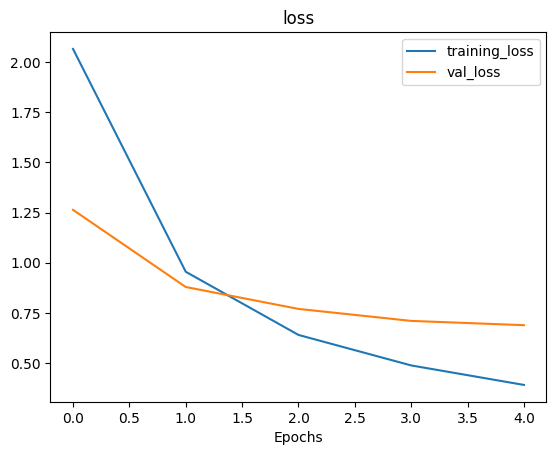

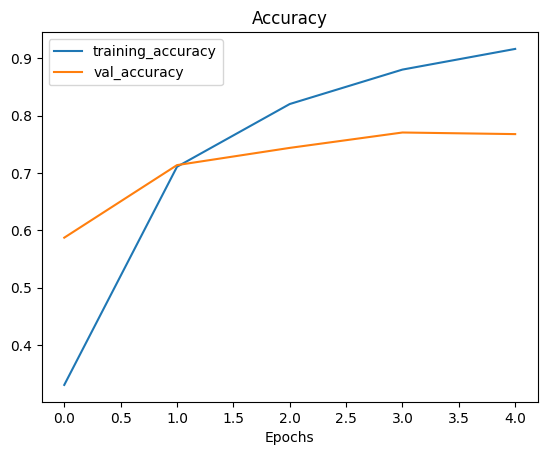

In [23]:
plot_loss_curves(resnet_history)

In [24]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


You can see the power of TensorFlow Hub here. The feature extraction layer has 23,564,800 parameters which are prelearned patterns the model has already learned on the ImageNet dataset. Since we set `trainable=False`, these patterns remain frozen (non-trainable) during training.

This means during training the model updates the 20,490 parameters in the output layer to suit our dataset.

Okay, we've trained a ResNetV250 model, time to do the same with EfficientNetB0 model.

The setup will be the exact same as before, except for the `model_url` parameter in the `create_model()` function and the `experiment_name` parameter in the `create_tensorboard_callback()` function.

In [25]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer='adam',
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20241111-193047
Epoch 1/5
24/24 [==============================] - 22s 517ms/step - loss: 1.8619 - accuracy: 0.4187 - val_loss: 1.3079 - val_accuracy: 0.7400
Epoch 2/5
24/24 [==============================] - 13s 542ms/step - loss: 1.0683 - accuracy: 0.7667 - val_loss: 0.8814 - val_accuracy: 0.8132
Epoch 3/5
24/24 [==============================] - 12s 529ms/step - loss: 0.7560 - accuracy: 0.8400 - val_loss: 0.7107 - val_accuracy: 0.8336
Epoch 4/5
24/24 [==============================] - 10s 410ms/step - loss: 0.5900 - accuracy: 0.8760 - val_loss: 0.6243 - val_accuracy: 0.8452
Epoch 5/5
24/24 [==============================] - 13s 557ms/step - loss: 0.5402 - accuracy: 0.8787 - val_loss: 0.5606 - val_accuracy: 0.8556


Holy smokes! The EfficientNetB0 model does even better than the ResNetV250 model! Achieving over 85% accuracy on the test set...again **with only 10% of the training data**.

How cool is that?

With a couple of lines of code we're able to leverage state of the art models and adjust them to our own use case.

Let's check out the loss curves.

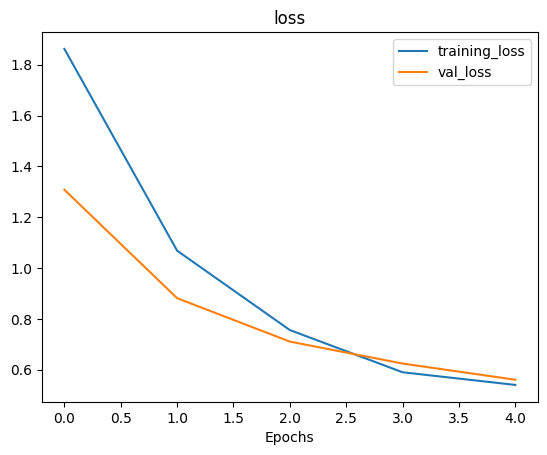

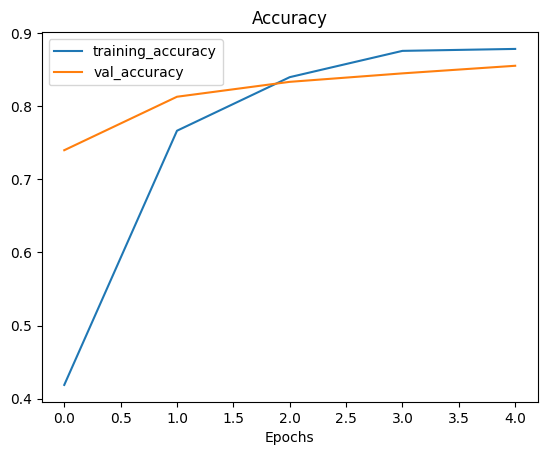

In [26]:
plot_loss_curves(efficientnet_history)

From the look of the EfficientNetB0 model's loss curves, it looks like if we kept training our model for longer, it might improve even further. Perhaps that's something you might want to try?

Let's check out the model summary.

In [27]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


It seems despite having over four times less parameters (4,049,564 vs. 23,564,800) than the ResNet50V2 extraction layer, the  EfficientNetB0 feature extraction layer yields better performance. Now it's clear where the "efficient" name came from.

## Comparing Models with TensorBoard

Although we've compared model performance using accuracy scores, TensorBoard provides a more powerful way to track multiple models and experiments. TensorBoard is preinstalled in Google Colab, and since we’ve set up a TensorBoard callback, all training logs are saved automatically.

You can upload results to [TensorBoard.dev](https://tensorboard.dev/) to track and share multiple experiments. This is useful for sharing results with others via a link to your TensorBoard.dev dashboard.

> 🔑 **Note:** Experiments are public, so avoid uploading sensitive data. You can delete experiments if needed.

### Uploading to TensorBoard

To upload TensorFlow logs, use the following command:

```bash
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two TF Hub models using 10% of training images" \
  --one_shot
  --logdir: Directory of the logs
  --name: Name of the experiment
  --description: Brief experiment description
  --one_shot: Exits uploader after uploading
  ```

  After authorizing the upload, your logs will be shared on TensorBoard.dev.

In [28]:
# upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

2024-11-11 19:32:18.439761: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731353538.459737   28200 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731353538.465791   28200 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
ERROR: The `tensorboard dev` command is no longer available.

TensorBoard.dev has been shut down. For further information,
see the FAQ at <https://tensorboard.dev/>.


In [29]:
# tensorboard --logdir ./tensorflow_hub/
# """
# tensorboard --logdir ./tensorflow_hub/

# """

Each upload to TensorBoard.dev generates a unique experiment ID, like [this one](https://tensorboard.dev/experiment/73taSKxXQeGPQsNBcVvY3g/). Uploading the same directory again creates a new ID.

To easily track experiments, name your uploads descriptively (e.g., "efficientnet0_10_percent_data").

### Listing Uploaded Experiments

Use the following command to see all your uploaded experiments:

```bash
tensorboard dev list


### Deleting experiments from TensorBoard

Remember, all uploads to TensorBoard.dev are public, so to delete an experiment you can use the command:

`tensorboard dev delete --experiment_id [INSERT_EXPERIMENT_ID]`



In [30]:
# !tensorboard dev delete --experiment_id ###################

## 🛠 Exercises

1. Build and fit a model using the same data we have here but with the MobileNetV2 architecture feature extraction ([`mobilenet_v2_100_224/feature_vector`](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4)) from TensorFlow Hub, how does it perform compared to our other models?
2. Name 3 different image classification models on TensorFlow Hub that we haven't used.
3. Build a model to classify images of two different things you've taken photos of.
  * You can use any feature extraction layer from TensorFlow Hub you like for this.
  * You should aim to have at least 10 images of each class, for example to build a fridge versus oven classifier, you'll want 10 images of fridges and 10 images of ovens.
4. What is the current best performing model on ImageNet?
  * Hint: you might want to check [sotabench.com](https://www.sotabench.com) for this.

## 📖 Extra-curriculum

* Read through the [TensorFlow Transfer Learning Guide](https://www.tensorflow.org/tutorials/images/transfer_learning) and define the main two types of transfer learning in your own words.
* Go through the [Transfer Learning with TensorFlow Hub tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub) on the TensorFlow website and rewrite all of the code yourself into a new Google Colab notebook making comments about what each step does along the way.
* We haven't covered fine-tuning with TensorFlow Hub in this notebook, but if you'd like to know more, go through the [fine-tuning a TensorFlow Hub model tutorial](https://www.tensorflow.org/hub/tf2_saved_model#fine-tuning) on the TensorFlow homepage.How to fine-tune a tensorflow hub model:  
* Look into [experiment tracking with Weights & Biases](https://www.wandb.com/experiment-tracking), how could you integrate it with our existing TensorBoard logs?

# **Ch-06: Transfer Learning with NN on Tensor Flow | Fine Tuning**


In the previous section, we explored **feature extraction transfer learning** to improve results with less data. Now, we'll focus on **fine-tuning**.

In **fine-tuning**, the pre-trained model weights are unfrozen and adjusted to better suit your own data. Unlike feature extraction, where only the top 1-3 layers are trained, fine-tuning can involve training 1-3+ layers or even all layers of the pre-trained model.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-transfer-learning-feature-extraction-vs-fine-tuning.png)

*Feature extraction vs. fine-tuning: In fine-tuning, more layers of the pre-trained model are unfrozen and trained on custom data. Fine-tuning typically requires more data to be effective.*


## What we're going to cover

In this section, we'll explore the following with TensorFlow:

- **Fine-tuning**: Modifying a pre-trained model to better fit your data.
- **Keras Functional API**: A different way to build models in Keras.
- **Smaller datasets**: Experimenting faster with 1-10% of training samples (10 food classes).
- **Data augmentation**: Increasing dataset diversity without adding more data.
- Running modeling experiments on our Food Vision data:
  - **Model 0**: Transfer learning with the Keras Functional API.
  - **Model 1**: Feature extraction with 1% of data and augmentation.
  - **Model 2**: Feature extraction with 10% of data and augmentation.
  - **Model 3**: Fine-tuned transfer learning with 10% of data.
  - **Model 4**: Fine-tuned transfer learning with 100% of data.
- **ModelCheckpoint**: Save intermediate training results.
- Compare experiment results using **TensorBoard**.




| **Aspect**            | **Feature Extraction**                                       | **Fine-tuning**                                        |
|-----------------------|--------------------------------------------------------------|--------------------------------------------------------|
| **Concept**           | Freeze pre-trained layers, retrain only top layers           | Unfreeze and retrain some or all layers                |
| **Usage**             | Best for small datasets and quick prototyping                | Best for larger datasets and higher accuracy           |
| **Training Time**     | Faster, less computation required                            | Slower, more layers to retrain                         |
| **Data Requirements** | Less data needed                                            | More data required for effective fine-tuning           |
| **Performance**       | Lower, may not adapt well to specific tasks                  | Higher, adapts more effectively to custom data         |
| **Advantages**        | Faster, less data, simple to implement                      | Better performance, more adaptable, high accuracy      |
| **Disadvantages**     | May not perform well on specialized tasks, limited adaptation| Slower, more data required, risk of overfitting        |
| **Suitability**       | Small datasets, similar tasks, quick tests                   | Large datasets, complex tasks requiring high accuracy |


In [31]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2024-11-11 19:32:22.812894




> 🔑 **Note:** As of TensorFlow 2.10+ there seems to be issues with the `tf.keras.applications.efficientnet` models (used later on) when loading weights via the `load_weights()` methods.
>
> To fix this, I've updated the code to use `tf.keras.applications.efficientnet_v2`, this is a small change but results in far less errors.
>
> You can see [the full write-up on the course GitHub](https://github.com/mrdbourke/tensorflow-deep-learning/discussions/575).

In [32]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


In [33]:
!nvidia-smi

Mon Nov 11 19:32:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0              30W /  70W |  12405MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2024-11-11 20:15:39--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-11-11 20:15:40 (9.30 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## 10 Food Classes: Working with Less Data

In the [previous notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb), we achieved great results with just 10% of the training data using transfer learning.

In this notebook, we’ll work with smaller subsets again, but focus on using pre-trained models from [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) and fine-tuning them for our dataset. We’ll also use the [`image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) function for data loading, similar to our previous approach.

Additionally, we’ll explore the [Keras Functional API](https://keras.io/guides/functional_api/) to build more flexible deep learning models.

Let’s begin by downloading the data.


In [3]:
import os
import zipfile
import urllib.request

# Define the file name and URL
file_name = "10_food_classes_10_percent.zip"
url = "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"

# Check if the file exists
if not os.path.exists(file_name):
    print(f"File {file_name} not found, downloading...")
    urllib.request.urlretrieve(url, file_name)
else:
    print(f"File {file_name} already exists.")

# Function to unzip the file
def unzip_data(zip_file):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall()
    print(f"Data from {zip_file} extracted.")

# Unzip the downloaded file
unzip_data(file_name)


File 10_food_classes_10_percent.zip not found, downloading...
Data from 10_food_classes_10_percent.zip extracted.


In [6]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

In [7]:
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

Now that we have image data, we need to load it in a TensorFlow-compatible format.

Previously, we used the [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator), but it is deprecated as of August 2023 due to performance issues. Instead, we'll use `tf.keras.utils.image_dataset_from_directory()`.

This method expects the following file structure:


```
Example of file structure

10_food_classes_10_percent <- top level folder
└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...    
```



The key advantage of `image_dataset_from_directory()` over `ImageDataGenerator` is that it creates a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset), which is more efficient and faster, especially for larger datasets.

Let's see how it works.


In [38]:
import tensorflow as tf

IMG_SIZE = (224,224)
batch_size = 32


train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=32)
# train_data_10_percent = train_data_10_percent.repeat()  # Repeat the dataset
# steps_per_epoch = len(train_data_10_percent) // batch_size
# validation_steps = len(test_data_10_percent) // batch_size
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Great! Our dataloaders have correctly found the images for each dataset.

The key parameters in `image_dataset_from_directory()` are:
- `directory`: the filepath of the target directory.
- `image_size`: the target size (height, width) of images.
- `batch_size`: the number of images per batch (default is 32).

You can explore more options in the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory).

Checking the training data’s datatype should show it as a `BatchDataset` with shapes corresponding to the data.


In [39]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In the above output:

* `(None, 224, 224, 3)` refers to the tensor shape of our images where `None` is the batch size, `224` is the height (and width) and `3` is the color channels (red, green, blue).
* `(None, 10)` refers to the tensor shape of the labels where `None` is the batch size and `10` is the number of possible labels (the 10 different food classes).
* Both image tensors and labels are of the datatype `tf.float32`.

The `batch_size` is `None` due to it only being used during model training. You can think of `None` as a placeholder waiting to be filled with the `batch_size` parameter from `image_dataset_from_directory()`.

Another benefit of using the `tf.data.Dataset` API are the assosciated methods which come with it.

For example, if we want to find the name of the classes we were working with, we could use the `class_names` attribute.

In [40]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

Or if we wanted to see an example batch of data, we could use the `take()` method.

In [41]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[2.11658173e+02 1.72658173e+02 1.29658173e+02]
   [2.27117355e+02 1.90025513e+02 1.46071442e+02]
   [2.27357147e+02 1.93571426e+02 1.48571426e+02]
   ...
   [2.49918381e+02 1.54285751e+02 4.94949265e+01]
   [2.49311218e+02 1.59688828e+02 5.29285965e+01]
   [2.49586716e+02 1.64556168e+02 5.61428909e+01]]

  [[2.15688782e+02 1.74163254e+02 1.28591843e+02]
   [2.24061218e+02 1.85928574e+02 1.40862259e+02]
   [2.25729599e+02 1.89556122e+02 1.44500000e+02]
   ...
   [2.45857162e+02 1.46000015e+02 3.44438744e+01]
   [2.45275528e+02 1.49372467e+02 3.77806473e+01]
   [2.45785675e+02 1.52188843e+02 4.18571777e+01]]

  [[2.19801025e+02 1.75785706e+02 1.26433670e+02]
   [2.23785721e+02 1.81658173e+02 1.33158173e+02]
   [2.26045914e+02 1.88306122e+02 1.41260208e+02]
   ...
   [2.47260193e+02 1.43428574e+02 2.79234562e+01]
   [2.47000000e+02 1.42770401e+02 2.93877602e+01]
   [2.44933640e+02 1.42076508e+02 3.15714283e+01]]

  ...

  [[1.48928543e+02 1.55505112e+02 1.92647995e+02]
   [1

Notice how the image arrays come out as tensors of pixel values where as the labels come out as one-hot encodings (e.g. `[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]` for `hamburger`).

| **Model** | **Data Size**  | **Transfer Learning Approach**       | **Augmentation**       | **Description**                                                                                                                                   |
|-----------|----------------|--------------------------------------|------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------|
| **Model 0** | Not specified  | General transfer learning using Keras Functional API | Not specified           | Uses Keras Functional API to create a custom transfer learning model. Doesn't specify data size ,  feature extraction.            |
| **Model 1** | 1% of the data | Feature extraction (pre-trained layers frozen) | Yes (data augmentation) | Uses 1% of the data for training. Pre-trained layers are frozen, only new layers are trained. Data augmentation is used to increase effective data. |
| **Model 2** | 10% of the data | Feature extraction (pre-trained layers frozen) | Yes (data augmentation) | Uses 10% of the data for training. Pre-trained layers are frozen, only new layers are trained. Data augmentation is used to increase effective data. |
| **Model 3** | 10% of the data | Fine-tuning (pre-trained layers updated) | No                     | Uses 10% of the data for training. Pre-trained layers are fine-tuned (updated) along with new layers. No data augmentation used.                  |
| **Model 4** | 100% of the data | Fine-tuning (pre-trained layers updated) | No                     | Uses 100% of the data for training. Pre-trained layers are fine-tuned (updated) along with new layers. No data augmentation used.                  |


## **Model 0: Building a Transfer Learning Model Using the Keras Functional API**

Let’s build our transfer learning model using the [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module and Keras Functional API.

Here are the steps:

1. **Instantiate a pre-trained base model** (e.g., [`EfficientNetV2B0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet_v2/EfficientNetV2B0)) with `include_top=False` (we’ll create our own top layers).
2. **Freeze the pre-trained model** by setting `trainable=False`.
3. **Define the input layer** for the model (e.g., input data shape).
4. **Normalize inputs** (optional, based on model requirements).
   > 🤔 **Note:** As of now, `EfficientNet` and `EfficientNetV2` don’t need input normalization, unlike other models.
5. **Pass the inputs to the base model.**
6. **Pool the outputs** using `GlobalAveragePooling2D` (or `GlobalMaxPooling2D`).
7. **Create the output layer** using `Dense()` with the appropriate activation and neuron count.
8. **Build the model** using `tf.keras.Model()`.
9. **Compile the model** with a loss function and optimizer.
10. **Fit the model** with the desired epochs and callbacks (e.g., TensorBoard).

Let’s see it in practice!


In [42]:

# base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
# # OLD
# # base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# # freezing
# base_model.trainable = False

# # iputs into base model
# inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# # 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# # x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)


# # passing inputs
# x = base_model(inputs)

# print(f"Shape after base_model: {x.shape}")

# # 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
# x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# # create output activation layer
# outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# # combine the inputs with output into model
# model_00 = tf.keras.Model(inputs, outputs)

# model_00.compile(loss="categorical_crossentropy",
#                 optimizer=tf.keras.optimizers.Adam(),
#                 metrics=["accuracy"])

# history_10_percent = model_0.fit(train_data_10_percent,
#                                  epochs=5,
#                                  steps_per_epoch=len(train_data_10_percent) // batch_size,
#                                  validation_data= test_data_10_percent,
#                                  # Go through less of the validation data so epochs are faster (we want faster experiments!)
#                                  validation_steps=int(0.25 * len(test_data_10_percent)),
#                                  callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])


In [43]:
import tensorflow as tf

# Define image size and batch size
IMG_SIZE = (224, 224)
batch_size = 32

# Load the datasets
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=batch_size
)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=batch_size
)

# Get the number of steps per epoch using cardinality()
steps_per_epoch = train_data_10_percent.cardinality().numpy()
validation_steps = int(0.25 * test_data_10_percent.cardinality().numpy())

# Optionally repeat the datasets if necessary (this will prevent "out of data" warning)
train_data_10_percent = train_data_10_percent.repeat()  # Repeat the training data
test_data_10_percent = test_data_10_percent.repeat()  # Repeat validation data

# Load EfficientNetV2 base model with pre-trained weights
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# Freeze the base model layers
base_model.trainable = False

# Create the input layer
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# Pass inputs through the base model
x = base_model(inputs)

print(f"Shape after base_model: {x.shape}")

# Global average pooling
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Output layer with softmax activation for multi-class classification
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Combine inputs and outputs into the final model
model_00 = tf.keras.Model(inputs, outputs)

# Compile the model
model_00.compile(loss="categorical_crossentropy",
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

# Fit the model with TensorBoard callback
history_10_percent = model_00.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=steps_per_epoch,  # Number of steps per epoch for training
    validation_data=test_data_10_percent,
    validation_steps=validation_steps,  # Number of steps for validation
    callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")]
)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
Shape after base_model: (None, 7, 7, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20241111-193229
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 46s 881ms/step - accuracy: 0.2895 - loss: 2.0837 - val_accuracy: 0.7368 - val_loss: 1.3147
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.7118 - loss: 1.2540 - val_accuracy: 0.8273 - val_loss: 0.8797
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.8150 - loss: 0.8625 - val_accuracy: 0.8438 - val_loss: 0.7228
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.8286 - loss: 0.7226 - val_accuracy: 0.8141 - val_loss: 0.6664
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 310ms/step - accuracy: 0.8450 - loss: 0.6316 - val_accuracy: 0.8500 - val_loss: 0.5957


1. **Create Base Model**: Instantiate a pre-trained model (e.g., EfficientNetV2B0) without the top layers (`include_top=False`) to add custom layers.

2. **Freeze the Base Model**: Set the base model's `trainable` attribute to `False` to keep the pre-trained weights fixed during training.

3. **Create Input Layer**: Define the input shape (e.g., 224x224 images with 3 channels).

4. **Optional Rescaling**: For models like ResNet50V2, normalize inputs by rescaling, not needed for EfficientNetV2.

5. **Pass Inputs to Base Model**: Feed inputs through the base model to extract features.

6. **Average Pooling**: Apply global average pooling to reduce dimensions and retain key features.

7. **Create Output Layer**: Add a softmax layer with neurons equal to the number of classes (e.g., 10 for food categories).

8. **Combine Model**: Merge the input and output layers to form the complete model.

9. **Compile the Model**: Compile with `categorical_crossentropy` loss, `Adam` optimizer, and `accuracy` metric.

10. **Fit the Model**: Train the model with data, using TensorBoard for progress tracking.


After training for a minute, our model performs exceptionally well on both the training and test sets, thanks to transfer learning.

We used **feature extraction transfer learning** by passing our custom data to a pre-trained model (`EfficientNetV2B0`), extracting patterns, and adding our output layer for the desired classes.

The model was built using the **Keras Functional API**, which offers more flexibility for complex models compared to the Sequential API.

> 📖 **Resource:** For more on the Functional API vs. Sequential API, check the [documentation](https://www.tensorflow.org/guide/keras/functional).

Next, let's inspect the layers of our model, starting with the base.


In [44]:
model_00.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

Our overall model has five layers but really, one of those layers (`efficientnetv2-b0`) has 269 layers.

You can see how the output shape started out as `(None, 224, 224, 3)` for the input layer (the shape of our images) but was transformed to be `(None, 10)` by the output layer (the shape of our labels), where `None` is the placeholder for the batch size.

Notice too, the only trainable parameters in the model are those in the output layer.

How do our model's training curves look?



In [45]:
base_model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, None, None, 3)  │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, None, None, 3)  │              0 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, None, None, 32) │            864 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, None, None, 32) │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, None, None, 32) │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, None, None, 16) │          4,608 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, None, None, 16) │             64 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, None, None, 16) │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_conv       │ (None, None, None, 64) │          9,216 │ block1a_project_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_bn         │ (None, None, None, 64) │            256 │ block2a_expand_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_activation │ (None, None, None, 64) │              0 │ block2a_expand_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_conv      │ (None, None, None, 32) │          2,048 │ block2a_expand_activa… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_bn        │ (None, None, None, 32) │            128 │ block2a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

In [46]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_layer
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 b

Wow, that's a lot of layers... to handcode all of those would've taken a fairly long time to do, yet we can still take advatange of them thanks to the power of transfer learning.

How about a summary of the base model?

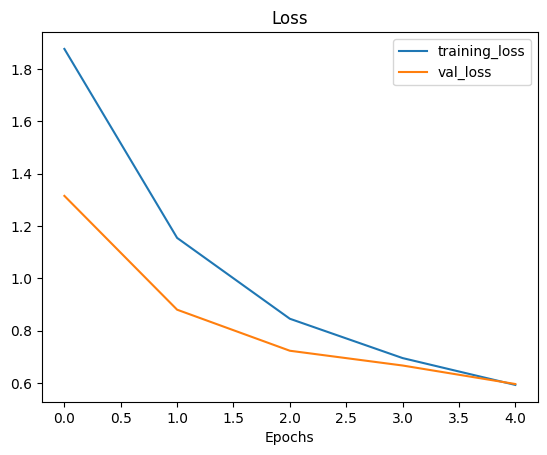

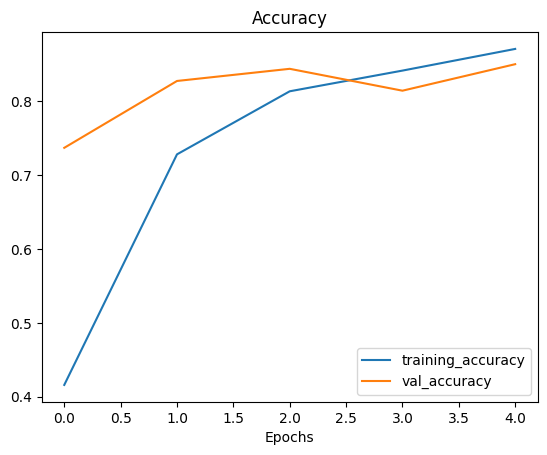

In [47]:
plot_loss_curves(history_10_percent)

### Getting a Feature Vector from a Trained Model

> 🤔 **Question:** What happens with the `tf.keras.layers.GlobalAveragePooling2D()` layer?

The [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer reduces a 4D tensor to a 2D tensor by averaging values across the inner axes.

For example, if the input tensor has a shape of `(1, 4, 4, 3)`, the `GlobalAveragePooling2D` layer converts it to `(1, 3)` by averaging across the middle two dimensions.

We can replicate this operation using `tf.reduce_mean()` by specifying the correct axes. This helps make the base model's output compatible with the output layer (`tf.keras.layers.Dense()`), and condenses the learned information into a **feature vector**.

> 🔑 **Note:** In feature extraction transfer learning, the pretrained model often outputs a **feature vector** (e.g., the result of the `GlobalAveragePooling2D` layer) that can be used to extract patterns.

> 🛠 **Practice:** Try the same with [`tf.keras.layers.GlobalMaxPool2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D).


In [48]:
# practicing

input_shape= (1,4,4,3)
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")   # (batch_size, height, width, channels)

# passing the random vector to a global pooling 2D
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")



Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]



**Global Average Pooling (2D)**

Global average pooling is a method used to reduce the spatial dimensions (height and width) of the tensor while retaining the information from each channel.

It works by averaging the values in each channel (for each position) across the entire spatial grid (height x width). Since your image is 4x4 with 3 channels (RGB), global average pooling will produce a single value per channel by averaging all the pixel values in that channel.

Let's break down the calculation:

For each channel (R, G, B), the average is calculated over the entire 4x4 grid.


![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*fXxDBsJ96FKEtMOa9vNgjA.gif)

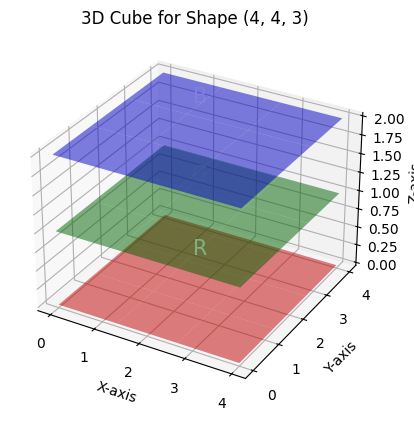

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the shape (4, 4, 3)
x_dim, y_dim, z_dim = 4, 4, 3

# Create a 3D grid to represent the cube
x = np.linspace(0, x_dim, x_dim)
y = np.linspace(0, y_dim, y_dim)
z = np.linspace(0, z_dim, z_dim)

# Create a meshgrid for plotting
X, Y = np.meshgrid(x, y)

# Initialize the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the cube as a wireframe and color each layer (R, G, B)
ax.plot_surface(X, Y, np.full_like(X, 0), alpha=0.5, color='red')  # Red layer
ax.plot_surface(X, Y, np.full_like(X, 1), alpha=0.5, color='green')  # Green layer
ax.plot_surface(X, Y, np.full_like(X, 2), alpha=0.5, color='blue')  # Blue layer

# Labels for each layer
ax.text(x_dim / 2, y_dim / 2, 0.5, 'R', color='white', fontsize=15, ha='center', va='center')
ax.text(x_dim / 2, y_dim / 2, 1.5, 'G', color='white', fontsize=15, ha='center', va='center')
ax.text(x_dim / 2, y_dim / 2, 2.5, 'B', color='white', fontsize=15, ha='center', va='center')

# Labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Title
ax.set_title('3D Cube for Shape (4, 4, 3)')

plt.show()


In [50]:
tf.reduce_mean(input_tensor, axis=[1,2]) # average across middle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

**bold text**## Running Transfer Learning Experiments

We’ve seen great results using 10% of the training data—let’s see what happens with just 1%!

In this series of experiments, we’ll explore how transfer learning performs with different amounts of training data:

1. **Model 1**: Feature extraction transfer learning on 1% of the data with augmentation.
2. **Model 2**: Feature extraction transfer learning on 10% of the data with augmentation, saving the results to a checkpoint.
3. **Model 3**: Fine-tune **Model 2** on 10% of the data with augmentation.
4. **Model 4**: Fine-tune **Model 2** on 100% of the data with augmentation.

All experiments will use the same test dataset for comparability and the `EfficientNetV2B0` model from `tf.keras.applications.efficientnet_v2`.

We'll log training using `create_tensorboard_callback()` and build data augmentation into the model via the `tf.keras.layers` module, instead of using `ImageDataGenerator`.

Let’s begin with **Model 1**, using 1% of the data with feature extraction and augmentation.


In [8]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2024-11-11 20:16:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.170.207, 173.194.174.207, 74.125.23.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.170.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  26.4MB/s    in 5.7s    

2024-11-11 20:16:35 (22.5 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [9]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There a

In [53]:

IMG_SIZE = (224, 224)

# Load the datasets
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                batch_size=batch_size,
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding Data Augmentation Directly into the Model

In previous experiments, we used the `ImageDataGenerator` class for data augmentation, but this time, we’ll integrate data augmentation directly into the model.

How?  
We’ll use the [`tf.keras.layers`](https://www.tensorflow.org/api_docs/python/tf/keras/layers) module to create a dedicated data augmentation layer.

This feature, introduced in TensorFlow 2.10+, provides several advantages:
- **GPU-based preprocessing**: Augmentation happens on the GPU, speeding up the process compared to CPU-based augmentation.
- **Model portability**: Augmentation only occurs during training, so the model can be exported and reused in other environments without the need for augmentation on the inference side.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-data-augmentation-inside-a-model.png)  
*Example of using data augmentation as the first layer within a model (EfficientNetB0).*

> 📚 **Resource:** For more details on data augmentation methods, refer to the [TensorFlow Data Augmentation Guide](https://www.tensorflow.org/tutorials/images/data_augmentation).

### Data Augmentation Layers Used:
- [`tf.keras.layers.RandomFlip`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip): Randomly flips images horizontally or vertically.
- [`tf.keras.layers.RandomRotation`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation): Randomly rotates images by a specified angle.
- [`tf.keras.layers.RandomZoom`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomZoom): Randomly zooms into the image by a specified factor.
- [`tf.keras.layers.RandomHeight`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomHeight): Randomly adjusts the height of the image.
- [`tf.keras.layers.RandomWidth`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomWidth): Randomly adjusts the width of the image.
- [`tf.keras.layers.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling): Rescales image pixel values between 0 and 1. This is important for some models but not needed for `EfficientNetV2B0`, as the pretrained model handles it.

These transformations will be combined into a **Keras Sequential model** and used as the first layer in our functional model.

Let’s get started by creating the augmentation layers and integrating them into the model!


In [54]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# from tensorflow.keras.layers.experimental import preprocessing

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
# data_augmentation = tf.keras.Sequential([
#     layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.2),
#     layers.RandomZoom(0.2),
#     layers.RandomHeight(0.2),
#     layers.RandomWidth(0.2),
# ], name="data_augmentation")
# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = tf.keras.Sequential([
    layers.Resizing(*IMG_SIZE),               # Ensure input size is 224x224
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
], name="data_augmentation")

# # UPDATE: Previous versions of TensorFlow (e.g. 2.4 and below used the tensorflow.keras.layers.experimental.processing API)
# # Create a data augmentation stage with horizontal flipping, rotations, zooms
# data_augmentation = keras.Sequential([
#   preprocessing.RandomFlip("horizontal"),
#   preprocessing.RandomRotation(0.2),
#   preprocessing.RandomZoom(0.2),
#   preprocessing.RandomHeight(0.2),
#   preprocessing.RandomWidth(0.2),
#   # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
# ], name ="data_augmentation")


original shape of the image is :  (512, 512, 3)
shape of the image after expanding with augment is :  (1, 207, 243, 3)
shape of the image after squeeze is :  (207, 243, 3)


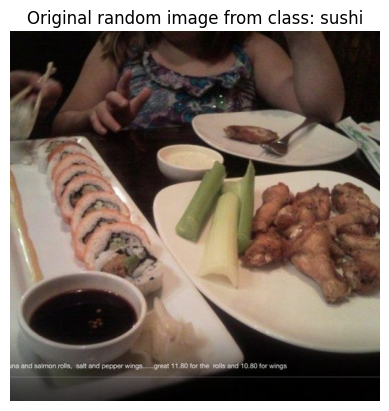

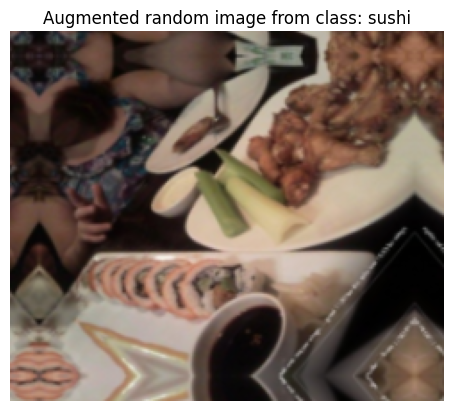

In [55]:
# testing for augmentation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

print("original shape of the image is : ",img.shape)

augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
# tf.expand_dims adds an extra dimension to the image img, effectively creating a batch dimension.
"""
axis=0 specifies that the new dimension should be added at the beginning,
making the shape of img go from, say, (height, width, channels) to
(1, height, width, channels).
"""
print("shape of the image after expanding with augment is : ",augmented_img.shape)

plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation

print("shape of the image after squeeze is : ",(tf.squeeze(augmented_img)).shape)
# tf.squeeze removes any dimensions of size 1 from the shape of augmented_img.

plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);



In [56]:
(tf.expand_dims(img, axis=0)).ndim

4

In [57]:
(tf.expand_dims(img, axis=0)).shape # this caused error in model_1 so must resize it for model_1

TensorShape([1, 512, 512, 3])

In [58]:
data_augmentation(tf.expand_dims(img, axis=0)).shape, data_augmentation(tf.expand_dims(img, axis=0)).ndim

# data_augmentation = tf.keras.Sequential([
#     layers.Resizing(*IMG_SIZE),               # Ensure input size is 224x224
#     layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.2),
#     layers.RandomZoom(0.2),
#     layers.RandomHeight(0.2),
#     layers.RandomWidth(0.2),
# ], name="data_augmentation")

(TensorShape([1, 222, 230, 3]), 4)

## **Model 1: Feature extraction transfer learning on 1% of the data with data augmentation**

In [59]:
len(train_data_1_percent) , len(test_data)

(3, 79)

In [60]:
batch_size = 32
input_shape = IMG_SIZE + (3,)


# Get the number of steps per epoch using cardinality()
steps_per_epoch = train_data_1_percent.cardinality().numpy()
validation_steps = int(0.25 * test_data.cardinality().numpy())

# Optionally repeat the datasets if necessary (this will prevent "out of data" warning)
train_data_1_percent = train_data_1_percent.repeat()  # Repeat the training data
test_data = test_data.repeat()  # Repeat validation data


In [61]:
from tensorflow.keras import layers, models

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.Resizing(*IMG_SIZE)  # Ensure output is always (224, 224, 3)
], name="data_augmentation")

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False,
    input_shape=input_shape  # Explicitly set to match data augmentation output
)
base_model.trainable = False
"""
By setting trainable to False, all the layers in base_model are "frozen," which means
they won’t learn or update their weights during the training process.
"""

# create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# add data aug
x = data_augmentation(inputs)

# give base model inputs and do not train it
x = base_model(x, training=False)

# pool output
x = layers.GlobalAveragePooling2D(name="global_avg_pooling_layer")(x)

outputs = layers.Dense(10,activation="softmax", name="output_layer")(x)

model_01 = models.Model(inputs, outputs)

model_01.compile(loss="categorical_crossentropy",
                 optimizer="adam",
                 metrics=["accuracy"])
history_1_percent = model_01.fit(train_data_1_percent,
                                 epochs=5,
                                 steps_per_epoch=steps_per_epoch,
                                 validation_data=test_data,
                                 validation_steps=validation_steps, # validate for less steps
                                 # Track model training logs
                                 callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")]
)

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20241111-193337
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.1040 - loss: 2.4743 - val_accuracy: 0.1414 - val_loss: 2.3145
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step - accuracy: 0.1924 - loss: 2.2644 - val_accuracy: 0.2171 - val_loss: 2.1622
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step - accuracy: 0.3914 - loss: 2.0166 - val_accuracy: 0.2961 - val_loss: 2.0811
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step - accuracy: 0.4844 - loss: 1.8720 - val_accuracy: 0.3816 - val_loss: 1.9763
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 744ms/step - accuracy: 0.6125 - loss: 1.7318 - val_accuracy: 0.4103 - val_loss: 1.8982


Wow!

Using just 7 training images per class with transfer learning, our model achieved ~45%+ accuracy on the validation set. This is impressive given that the [original Food-101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) achieved 50.67% accuracy with 750 images per class (across 101 classes, while we're working with 10 classes).

A model summary should show the data augmentation layer right after the input layer.


In [62]:
model_01.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_avg_pooling_layer             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

There it is. We've now got data augmentation built right into the our model. This means if we saved it and reloaded it somewhere else, the data augmentation layers would come with it.

The important thing to remember is **data augmentation only runs during training**. So if we were to evaluate or use our model for inference (predicting the class of an image) the data augmentation layers will be automatically turned off.

To see this in action, let's evaluate our model on the test data.

In [63]:
# result_1_percent_data_aug = model_01.evaluate(test_data)
# result_1_percent_data_aug

In [64]:
result_1_percent_data_aug = model_01.evaluate(test_data, steps=validation_steps)
result_1_percent_data_aug

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.3821 - loss: 1.9012


[1.9077541828155518, 0.3947368562221527]

The results here may be slightly better/worse than the log outputs of our model during training because during training we only evaluate our model on 25% of the test data using the line `validation_steps=int(0.25 * len(test_data))`. Doing this speeds up our epochs but still gives us enough of an idea of how our model is going.

Let's stay consistent and check out our model's loss curves.

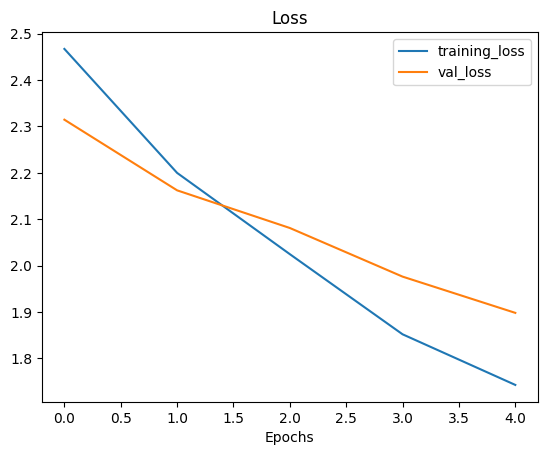

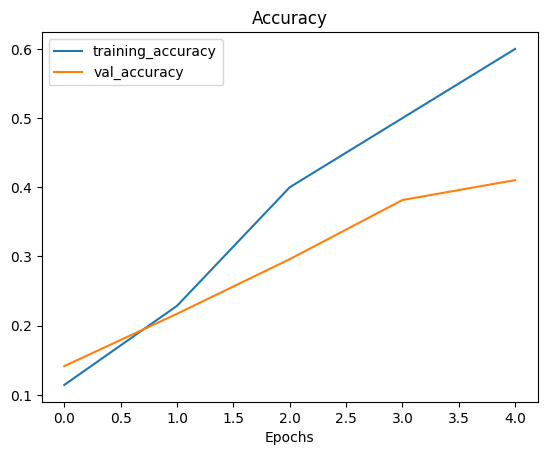

In [65]:
plot_loss_curves(history_1_percent)

It looks like the metrics on both datasets would improve if we kept training for more epochs. But we'll leave that for now, we've got more experiments to do!

## **Model 2: Feature Extraction Transfer Learning with 10% Data and Data Augmentation**

We've tested with 1% of the data, now let's scale up to 10% with data augmentation.

> 🤔 **Question:** How do you decide on experiments to run?

Often, you won't know exactly what to try. Machine learning is experimental; intuition develops with practice. Follow your curiosity, test ideas, and learn from what doesn’t work.

Practically, aim to shorten the time between experiments. Start with smaller experiments (less data, fewer iterations) to find promising directions, then scale up.

Now, let’s repeat our previous steps, this time using 10% of the training data.
                                                                            

In [32]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
from tensorflow.keras import layers, models


In [10]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [16]:
# print(os.listdir(train_dir_10_percent))


['sushi', 'pizza', 'ice_cream', 'hamburger', 'grilled_salmon', 'steak', 'ramen', 'chicken_wings', 'fried_rice', 'chicken_curry']


In [17]:
# print(os.listdir(test_dir))


['sushi', 'pizza', 'ice_cream', 'hamburger', 'grilled_salmon', 'steak', 'ramen', 'chicken_wings', 'fried_rice', 'chicken_curry']


In [19]:
import os

# Define the directories
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

# Function to count images in each class and aggregate total count
def count_images_in_directory(directory):
    total_images = 0  # Variable to hold the total image count

    # Loop over each class in the directory
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)

        # Check if it's a directory and count the image files
        if os.path.isdir(class_path):
            image_count = len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))])  # Add more extensions if needed
            total_images += image_count  # Add the count for this class

    return total_images

# Count total images in train and test directories
train_total = count_images_in_directory(train_dir_10_percent)
test_total = count_images_in_directory(test_dir)

# Display the results
print(f"Total Images in Train Directory: {train_total}")
print(f"Total Images in Test Directory: {test_total}")


Total Images in Train Directory: 750
Total Images in Test Directory: 2500


In [28]:
# create data laoder

import tensorflow as tf
import math

IMG_SIZE = (224, 224)
batch_size = 32  # Ensure batch size is defined

# Load datasets from directory
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_10_percent,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=batch_size  # Batch size is now defined
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=batch_size  # Batch size is now defined
)


validation_data = test_data




Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


We've got 10x more images to work with, 75 per class instead of 7 per class.


In [68]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers.experimental import preprocessing # OLD

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
], name="data_augmentation")

## OLD
# # Build data augmentation layer
# data_augmentation = Sequential([
#   preprocessing.RandomFlip('horizontal'),
#   preprocessing.RandomHeight(0.2),
#   preprocessing.RandomWidth(0.2),
#   preprocessing.RandomZoom(0.2),
#   preprocessing.RandomRotation(0.2),
#   # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
# ], name="data_augmentation")

input_shape = (224,224,3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
# pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_02= tf.keras.Model(inputs, outputs)

model_02.compile(loss="categorical_crossentropy",
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 metrics=["accuracy"])


To save time for later (when we want to perform multiple experiments with `model_2`), let's put the code above into a function we can resuse.

In [33]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
], name ="data_augmentation")

def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
  """
  Create a model based on EfficientNetV2B0 with built-in data augmentation.

  Parameters:
  - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
  - output_shape (int): Number of classes for the output layer. Default is 10.
  - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
  - training (bool): Whether the base model is trainable. Default is False.

  Returns:
  - tf.keras.Model: The compiled model with specified input and output settings.
  """
  # create base model
  base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
  base_model.trainable = training

  # setup model input and outputs with data augmentation build-in
  inputs = layers.Input(shape=input_shape, name="input_layers")
  x = data_augmentation(inputs)
  x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode
  x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
  outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
  model = tf.keras.Model(inputs, outputs)

  model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=["accuracy"])
  return model

In [34]:
model_2 = create_base_model()

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


### Creating a ModelCheckpoint Callback

Before fitting the model, we’ll introduce the `ModelCheckpoint` callback.

The [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback allows us to save the entire model or just its weights during training, to a specified directory. This is useful for long training sessions, enabling you to save progress and reload the model later to continue training, if needed.

For example, after 5 epochs of training, if the model's performance is still improving, you can load a checkpoint, unfreeze some base model layers, and continue training.

Now, let’s create the `ModelCheckpoint` callback and specify a directory to save to.


In [35]:
# setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.weights.h5"
 # note: remember saving directly to Colab is temporary
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,# save only the best model weights instead of a model every epoch
                                                         save_freq="epoch",
                                                         verbose=1)

| **Code Step**                                  | **Description**                                                                                 |
|-------------------------------------------------|-------------------------------------------------------------------------------------------------|
| `checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"` | Defines the path where the model checkpoints (weights) will be saved.                         |
| `checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(...)` | Creates a callback for saving the model weights during training.                                |
| `filepath=checkpoint_path`                      | Specifies the file path where the checkpoint will be saved.                                    |
| `save_weights_only=True`                        | Ensures only model weights (not the entire model) are saved.                                    |
| `save_best_only=True`                           | Saves only the model weights when the validation accuracy improves.                            |
| `save_freq="epoch"`                             | Specifies that the model weights will be saved after each epoch.                               |
| `verbose=1`                                     | Outputs messages when saving model weights after each epoch.                                   |



> 🤔 **Question:** What's the difference between saving the entire model (SavedModel format) and saving only the weights?

The [`SavedModel`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) format saves the model's architecture, weights, and training configuration, allowing you to reload the model exactly as it was. If you prefer not to share the full details (architecture, training configurations), or if disk space is a concern, saving only the weights (large tensors of numbers) is more efficient and uses less storage.

Now, let's fit the model.

We'll set `initial_epochs` to 5, as we'll be fine-tuning the model later. Additionally, we'll include the `checkpoint_callback` in our list of callbacks.


In [36]:
len(test_data)

79

In [37]:
int(0.25 * len(test_data))

19

In [38]:
# fit the model saving checkpoints every epoch
# Define the number of initial epochs
initial_epochs = 5

# Fit the model, saving checkpoints every epoch
history_10_percent_data_aug = model_2.fit(
    train_data_10_percent,
    epochs=initial_epochs,
    validation_data=validation_data,
    #steps_per_epoch=steps_per_epoch,
    # validation_steps=validation_steps,
    validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
    callbacks=[
        create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
        checkpoint_callback
    ]
)


Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20241111-205436
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1971 - loss: 2.1949
Epoch 1: val_loss improved from inf to 1.55453, saving model to ten_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.2018 - loss: 2.1879 - val_accuracy: 0.5970 - val_loss: 1.5545
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5833 - loss: 1.5398
Epoch 2: val_loss improved from 1.55453 to 1.13942, saving model to ten_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.5851 - loss: 1.5365 - val_accuracy: 0.7385 - val_loss: 1.1394
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6995 - loss: 1.1835
Epoch 3: val_loss improved from 1.13942 to 0.86017, saving model to ten_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.699

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 5: val_loss improved from 0.78768 to 0.59159, saving model to ten_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 113s 5s/step - accuracy: 0.7960 - loss: 0.8954 - val_accuracy: 0.8971 - val_loss: 0.5916


The `ModelCheckpoint` callback worked! The model saved weights every epoch with minimal overhead (saving weights is faster than saving the entire model).

Now, let's evaluate the model and check its loss curves.


In [39]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.8242 - loss: 0.6832


[0.6899408102035522, 0.824400007724762]

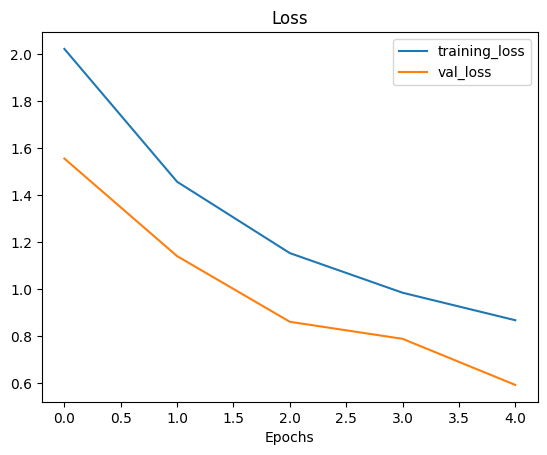

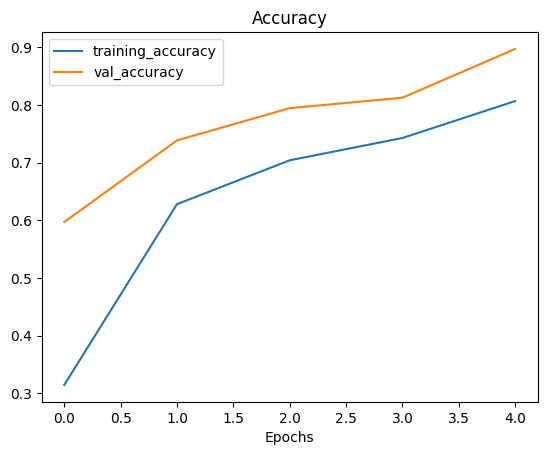

In [40]:
plot_loss_curves(history_10_percent_data_aug)

The model with 10% data and data augmentation isn't performing as well as the model without augmentation, but the curves are improving. If we train longer, the metrics could improve.

Since we saved the model's weights, let's load them back and test if they saved correctly by evaluating on the test data.

To load saved weights, use the [`load_weights()`](https://www.tensorflow.org/tutorials/keras/save_and_load#checkpoint_callback_options) method and pass the saved weights' path.


In [42]:
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.8152 - loss: 0.6974


Now let's compare the results of our previously trained model and the loaded model. These results should very close if not exactly the same. The reason for minor differences comes down to the precision level of numbers calculated.

In [43]:
results_10_percent_data_aug == loaded_weights_model_results

False

If the above cell doesn't output `True`, it's because the numbers are close but not the *exact* same (due to how computers store numbers with degrees of precision).

However, they should be *very* close...

In [44]:
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [45]:
# Check the difference between the two results (small values)
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-1.78813934e-07  0.00000000e+00]


## **Model 3: Fine-tuning an Existing Model on 10% of the Data**

In our previous experiment, we trained the model using feature extraction transfer learning for 5 epochs on 10% of the training data with data augmentation. During this training, all layers in the base model (`EfficientNetV2B0`) were frozen.

For the next experiment, we're switching to fine-tuning transfer learning. This means we'll unfreeze some of the layers in the base model, particularly those closer to the output, and run the model for additional epochs. Fine-tuning helps customize the pre-trained model more for our data.

> 🔑 **Note:** Fine-tuning works best *after* training a feature extraction model for a few epochs, especially with large data. For more details, check out [Keras' guide on Transfer Learning & Fine-tuning](https://keras.io/guides/transfer_learning/).

Now that we've verified the loaded model's performance, let's inspect its layers.


In [47]:
model_2.layers

[<InputLayer name=input_layers, built=True>,
 <Sequential name=data_augmentation, built=True>,
 <Functional name=efficientnetv2-b0, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling_layer, built=True>,
 <Dense name=output_layer, built=True>]

> **How about we check their names, numbers and if they're trainable?**

In [48]:
for layer_number, layer in enumerate(model_2.layers):
  print(f"Layer number: {layer_number} | Layer name: {layer.name} | layer type: {layer} | Trainable? {layer.trainable}")


Layer number: 0 | Layer name: input_layers | layer type: <InputLayer name=input_layers, built=True> | Trainable? True
Layer number: 1 | Layer name: data_augmentation | layer type: <Sequential name=data_augmentation, built=True> | Trainable? True
Layer number: 2 | Layer name: efficientnetv2-b0 | layer type: <Functional name=efficientnetv2-b0, built=True> | Trainable? False
Layer number: 3 | Layer name: global_average_pooling_layer | layer type: <GlobalAveragePooling2D name=global_average_pooling_layer, built=True> | Trainable? True
Layer number: 4 | Layer name: output_layer | layer type: <Dense name=output_layer, built=True> | Trainable? True


In [49]:
model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layers (InputLayer)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, None, None, 1280)    │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

Alright, it looks like all of the layers in the `efficientnetv2-b0` layer are frozen. We can confirm this using the `trainable_variables` attribute.

> **Note:** The layers of `base_model` (our `efficientnetv2-b0` feature extractor) of `model_2` is accessible by referencing `model_2.layers[2]`.

In [50]:
# access base model layers of model_2
model_2_base_model = model_2.layers[2]
model_2_base_model.name

'efficientnetv2-b0'

In [51]:
# how many layers are trainable in our model_2 base model?
print(len(model_2_base_model.trainable_variables))

0


We can even check layer by layer to see if the they're trainable.

To access the layers in `model_2_base_model`, we can use the `layers` attribute.

In [52]:
# check whuch layers are tunable
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)


0 input_layer False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

Beautiful! Now that we have our model ready, it's time to fine-tune it by unfreezing the top 10 layers and continuing training for another 5 epochs. This will update the weights in the unfrozen layers while keeping the remaining layers frozen and untrainable.

Fine-tuning is all about experimenting with the number of layers to unfreeze. There’s no fixed rule, but typically, when working with less data, it's better to unfreeze fewer layers and fine-tune gradually. Experimenting with different configurations is key to understanding what works best for your data.

> 🤔 **Question:** How many layers should you unfreeze when training?  
It varies! Try different strategies—unfreeze all layers, or just a few at a time—to see what yields the best results.

> 📖 **Resource:** The [ULMFiT paper](https://arxiv.org/abs/1801.06146) provides great insights into fine-tuning models.

To begin fine-tuning, we’ll unfreeze the entire `model_2_base_model` by setting its `trainable` attribute to `True`. Then, we’ll loop through its layers and freeze all but the last 10. Finally, we’ll recompile the model.


In [53]:
model_2_base_model.trainable = True

# freeze all layers except last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])


Wonderful, now let's check which layers of the pretrained model are trainable.

In [54]:
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)


0 input_layer False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

Nice! It looks like all layers except the last 10 are frozen, meaning only these 10 layers and the output layer will update during training.

> 🤔 **Question:** Why recompile the model?

Any change to the model requires recompiling. Here, we use the same loss, optimizer, and metrics, but with a smaller learning rate (`0.0001`) to prevent overwriting the pre-trained model’s weights too quickly. This makes learning more gradual.

> 🔑 **Note:** While there’s no fixed standard for fine-tuning learning rates, reductions of 2.6x-10x tend to work well.

Now, how many trainable variables do we have?


In [55]:
print(len(model_2.trainable_variables))

12


Great! Our model has 12 trainable variables: the last 10 layers of the base model and the weight and bias parameters of the Dense output layer.

Now, let's fine-tune!

We’ll continue training from where our previous model left off (after 5 epochs). By using the `initial_epoch` parameter in the `fit()` method, we'll resume training from epoch 5 and run for an additional 5 epochs. This is done by passing the last epoch from the previous model’s training history (`history_10_percent_data_aug.epoch[-1]`).


In [56]:
# tf.keras.backend.clear_session()

In [57]:
len(test_data), len(validation_data)

(79, 79)

In [58]:

# IMG_SIZE = (224, 224)
# batch_size = 32  # Ensure batch size is defined

# # Load datasets from directory
# train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
#     train_dir_10_percent,
#     label_mode="categorical",
#     image_size=IMG_SIZE,
#     batch_size=batch_size  # Batch size is now defined
# )
# # Load datasets from directory
# train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
#     train_dir_10_percent,
#     label_mode="categorical",
#     image_size=IMG_SIZE,
#     batch_size=batch_size  # Batch size is now defined
# )
# test_data = tf.keras.preprocessing.image_dataset_from_directory(
#     test_dir,
#     label_mode="categorical",
#     image_size=IMG_SIZE,
#     batch_size=batch_size  # Batch size is now defined
# )
# test_data = tf.keras.preprocessing.image_dataset_from_directory(
#     test_dir,
#     label_mode="categorical",
#     image_size=IMG_SIZE,
#     batch_size=batch_size  # Batch size is now defined
# )

# # Ensure datasets are loaded properly
# print("len of test data", len(test_data))
# print("len of train_data_10_percent", len(train_data_10_percent))

# # Safeguard to avoid division by zero or incorrect steps calculation
# if len(train_data_10_percent) == 0 or len(test_data) == 0:
#     raise ValueError("Training or test dataset is empty. Please check the data directory.")

# # Validate the test data size for 25% validation split
# validation_data_size = int(1 * len(test_data))
# if validation_data_size == 0:
#     raise ValueError("Validation dataset size is 0. Please check the test dataset.")

# validation_data = test_data.take(validation_data_size)
# # Validate the lengths of the validation data
# print("validation_data_size", validation_data_size)
# print("len of validation_data", len(validation_data))

# # Calculate steps dynamically with checks
# steps_per_epoch = len(train_data_10_percent) // batch_size  # Integer division for steps
# validation_steps = validation_data_size // batch_size  # Integer division for validation steps

# # Ensure steps are not zero
# if steps_per_epoch == 0:
#     raise ValueError("Steps per epoch is 0. Ensure that your training dataset is large enough and the batch size is appropriate.")

# if validation_steps == 0:
#     raise ValueError("Validation steps is 0. Ensure that the validation dataset is large enough and the batch size is appropriate.")

# print("steps_per_epoch", steps_per_epoch)
# print("validation_steps", validation_steps)



In [59]:
########################################################################

# Fine-tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

########################################################################
# Fit the model, saving checkpoints every epoch
history_fine_10_percent_data_aug = model_2.fit(
  train_data_10_percent,
  epochs=fine_tune_epochs,
  initial_epoch=history_10_percent_data_aug.epoch[-1],  # Start from epoch 5

  validation_data=validation_data,
  validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)

  callbacks=[create_tensorboard_callback("transfer_learning",
                                         "10_percent_fine_tune_last_10")
            ]
)
# Re-fit the model with updated steps per epoch and validation steps
# history_fine_10_percent_data_aug = model_2.fit(
#     train_data_10_percent,
#     epochs=fine_tune_epochs,  # Total of 10 epochs, but will start from epoch 5
#     initial_epoch=history_10_percent_data_aug.epoch[-1],  # Start from epoch 5
#     validation_data=test_data,
#     steps_per_epoch=steps_per_epoch,  # Specify steps per epoch
#     validation_steps=validation_steps,  # Specify validation steps
#     callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]
# )


"""
history_fine_10_percent_data_aug = model_2.fit(
    train_data_10_percent,
    epochs=fine_tune_epochs,  # total of 10 epochs, but will start from epoch 5
    validation_data=test_data,
    initial_epoch=history_10_percent_data_aug.epoch[-1],  # start from epoch 5 (the last epoch of the previous training)
    validation_steps=int(0.25 * len(test_data)),
    callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]
)
we could use this techinque to start from epoch 5 also as last implememntation
"""

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20241111-211200
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.7040 - loss: 1.0475 - val_accuracy: 0.8125 - val_loss: 0.7609
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.7728 - loss: 0.9080 - val_accuracy: 0.8388 - val_loss: 0.6619
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.7792 - loss: 0.8700 - val_accuracy: 0.8388 - val_loss: 0.6371
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/step - accuracy: 0.7955 - loss: 0.8122 - val_accuracy: 0.8586 - val_loss: 0.5590
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8099 - loss: 0.7755 - val_accuracy: 0.8676 - val_loss: 0.4410
Epoch 10/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


24/24 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.8469 - loss: 0.6880 - val_accuracy: 0.8487 - val_loss: 0.5245


'\nhistory_fine_10_percent_data_aug = model_2.fit(\n    train_data_10_percent,\n    epochs=fine_tune_epochs,  # total of 10 epochs, but will start from epoch 5\n    validation_data=test_data,\n    initial_epoch=history_10_percent_data_aug.epoch[-1],  # start from epoch 5 (the last epoch of the previous training)\n    validation_steps=int(0.25 * len(test_data)),\n    callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]\n)\nwe could use this techinque to start from epoch 5 also as last implememntation\n'

> 🔑 **Note:** Fine-tuning usually takes far longer per epoch than feature extraction (due to updating more weights throughout a network).

Ho ho, looks like our model has gained a few percentage points of accuracy! Let's evalaute it.

In [60]:
# evaluate the model on the total test data
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.8493 - loss: 0.5225


Remember, the results from evaluating the model might be slightly different to the outputs from training since during training we only evaluate on 25% of the test data.

Alright, we need a way to evaluate our model's performance before and after fine-tuning. How about we write a function to compare the before and after?

In [61]:
def compare_history(original_history, new_history, initial_epochs=5):
  """
  compares two model history objects
  """
  # get original history measurements
  acc = original_history.history["accuracy"]
  loss= original_history.history["loss"]

  print(len(acc))

  val_acc = original_history.history["val_accuracy"]
  val_loss= original_history.history["val_loss"]

  # combine original history with new gistory
  total_acc  = acc  + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc  = val_acc  + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  print(len(total_acc))
  print(total_acc)

  # make plots
  plt.figure(figsize=(8, 8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Validation Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1],
           plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2,1,2)
  plt.plot(total_loss, label='Training Loss')
  plt.plot(total_val_loss, label='Validation Loss')
  plt.plot([initial_epochs-1, initial_epochs-1],
           plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()



This is where saving the history variables of our model training comes in handy. Let's see what happened after fine-tuning the last 10 layers of our model.

5
11
[0.31466665863990784, 0.628000020980835, 0.7039999961853027, 0.7426666617393494, 0.8066666722297668, 0.7360000014305115, 0.7773333191871643, 0.7893333435058594, 0.8053333163261414, 0.8199999928474426, 0.8293333053588867]


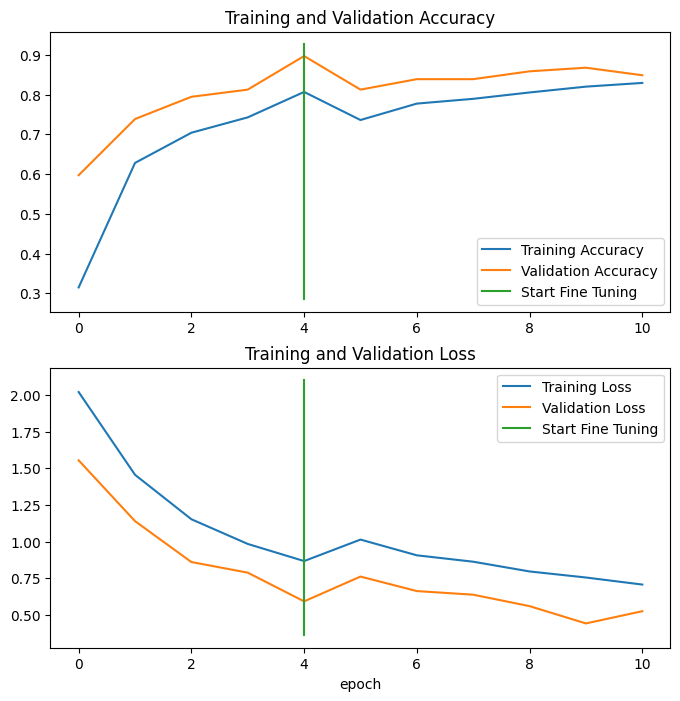

In [62]:
compare_history(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_percent_data_aug,
                 initial_epochs=5)


Alright, alright, seems like the curves are heading in the right direction after fine-tuning. But remember, it should be noted that fine-tuning usually works best with larger amounts of data.

## **Model 4: Fine-tuning an existing model all of the data**

Enough talk about how fine-tuning a model usually works with more data, let's try it out.

We'll start by downloading the full version of our 10 food classes dataset.



In [63]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2024-11-11 21:26:06--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.207, 64.233.189.207, 108.177.97.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  30.9MB/s    in 19s     

2024-11-11 21:26:27 (25.6 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [64]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.

In [65]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Oh this is looking good. We've got 10x more images in of the training classes to work with.

The **test dataset is the same** we've been using for our previous experiments.

As it is now, our `model_2` has been fine-tuned on 10 percent of the data, so to begin fine-tuning on all of the data and keep our experiments consistent, we need to revert it back to the weights we checkpointed after 5 epochs of feature-extraction.

To demonstrate this, we'll first evaluate the current `model_2`.

In [66]:
model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.8508 - loss: 0.5373


[0.5257563591003418, 0.8500000238418579]

These are the same values as `results_fine_tune_10_percent`.

In [67]:
results_fine_tune_10_percent

[0.5257562398910522, 0.8500000238418579]

### Experiment Setup: Fine-Tuning Models on 10% and 100% of the Data

To ensure consistency and clear results, we'll create a new instance of `model_2` using the `create_base_model()` function.

We will conduct two experiments:
- **Experiment 3 (previous)**: Fine-tune `model_2` for **5 additional epochs** on **10%** of the data, starting from the checkpoint of the model trained for 5 epochs.
- **Experiment 4 (current)**: Fine-tune `model_2` for **5 more epochs** on **100%** of the data, also starting from the same checkpoint as in Experiment 3.

Both experiments will be evaluated using the **same test data** to ensure comparability, and both will start from the **same checkpoint** (`model_2` trained on 10% of the data for 5 epochs).

Let's first create a new instance of `model_2` to start the experiments.


In [68]:
# create new instance from model_2 exp-4
model_2 = create_base_model(learning_rate=0.0001) # 10x lower learning rate for fine-tuning


In [69]:
model_2.load_weights(checkpoint_path)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [70]:
model_2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layers (InputLayer)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, None, None, 1280)    │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,932,122 (22.63 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [71]:
print(len(model_2.trainable_variables))

2


Nice! This is the same as our original checkpoint.

And the results should be the same as `results_10_percent_data_aug`.

In [72]:
# After loading the weights, this should have gone down (no fine-tuning)
model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8168 - loss: 0.6979


[0.6899409890174866, 0.824400007724762]

Alright, the previous steps might seem quite confusing but all we've done is:
1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using `ModelCheckpoint` (**Model 2**).
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (**Model 3**).
3. Saved the results and training logs each time.
4. Reloaded the model from 1 to do the same steps as 2 but with all (100%) of the data (**Model 4**).

The same steps as 2?

Yeah, we're going to fine-tune the last 10 layers of the base model with the full dataset for another 5 epochs but first let's remind ourselves which layers are trainable.

In [73]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layers True
1 data_augmentation True
2 efficientnetv2-b0 False
3 global_average_pooling_layer True
4 output_layer True


In [74]:
# Unfreeze the top 10 layers in model_2's base_model
model_2_base_model = model_2.layers[2]
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

Now let's make sure the right layers are trainable (we only want the last 10 to be trainable).

> **Note:** You could experiment which number of layers should be trainable here. Generally, the more data you have, the more layers that can be fine-tuned.

In [75]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dw

Looking good! The last 10 layers are trainable (unfrozen).

We've got one more step to do before we can begin fine-tuning.

Do you remember what it is?

I'll give you a hint. We just reloaded the weights to our model and what do we need to do every time we make a change to our models?

Recompile them!

This will be just as before.

In [76]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [77]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 5


In [78]:
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20241111-213231
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 583s 2s/step - accuracy: 0.7109 - loss: 1.0404 - val_accuracy: 0.8586 - val_loss: 0.4617
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 639s 2s/step - accuracy: 0.7710 - loss: 0.7500 - val_accuracy: 0.8964 - val_loss: 0.3645
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 568s 2s/step - accuracy: 0.8028 - loss: 0.6586 - val_accuracy: 0.9030 - val_loss: 0.2977
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 585s 2s/step - accuracy: 0.8150 - loss: 0.6167 - val_accuracy: 0.9030 - val_loss: 0.3065
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8305 - loss: 0.5662

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


235/235 ━━━━━━━━━━━━━━━━━━━━ 540s 2s/step - accuracy: 0.8305 - loss: 0.5662 - val_accuracy: 0.9265 - val_loss: 0.2206
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 664s 3s/step - accuracy: 0.8353 - loss: 0.5394 - val_accuracy: 0.8964 - val_loss: 0.2585


> 🔑 **Note:** Training took longer per epoch, but that makes sense because we're using 10x more training data than before.

Let's evaluate on all of the test data.

In [79]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.9061 - loss: 0.2585


[0.2611689269542694, 0.9124000072479248]

In [80]:
results_fine_tune_10_percent

[0.5257562398910522, 0.8500000238418579]

Nice! It looks like fine-tuning with all of the data has given our model a boost, how do the training curves look?

5
11
[0.31466665863990784, 0.628000020980835, 0.7039999961853027, 0.7426666617393494, 0.8066666722297668, 0.7417333126068115, 0.7794666886329651, 0.8055999875068665, 0.8198666572570801, 0.8297333121299744, 0.8371999859809875]


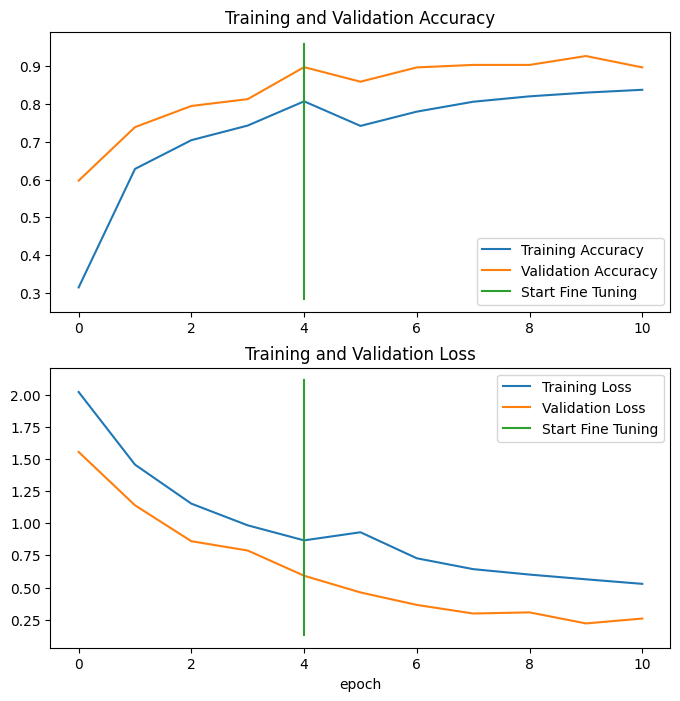

In [82]:
compare_history(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

Looks like that extra data helped! Those curves are looking great. And if we trained for longer, they might even keep improving.

## 🛠 Exercises

1. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.
2. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using [`tf.keras.applications.efficientnet_v2.EfficientNetV2B0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet_v2/EfficientNetV2B0) as the base model. Use the [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback to save the weights to file.
3. Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. How did it go?
4. Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs. How did it go?

## 📖 Extra-curriculum

* Read the [documentation on data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) in TensorFlow.
* Read the [ULMFit paper](https://arxiv.org/abs/1801.06146) (technical) for an introduction to the concept of freezing and unfreezing different layers.
* Read up on learning rate scheduling (there's a [TensorFlow callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler) for this), how could this influence our model training?
  * If you're training for longer, you probably want to reduce the learning rate as you go... the closer you get to the bottom of the hill, the smaller steps you want to take. Imagine it like finding a coin at the bottom of your couch. In the beginning your arm movements are going to be large and the closer you get, the smaller your movements become.

# **Ch-07: Transfer Learning with NN on Tensor Flow | Scaling up**


In this notebook, we’ll scale up our model from using 10 classes of the Food101 dataset to the full dataset, aiming to beat the original Food101 paper's results with just 10% of the data.


Our goal is to **beat the original [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)'s results with 10% of data**.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/06-ml-serial-experimentation.png)
*Machine learning practitioners are serial experimenters. Start small, get a model working, see if your experiments work then gradually scale them up to where you want to go (we're going to be looking at scaling up throughout this notebook).*

## Key Steps:
- Download and prepare 10% of the Food101 data
- Train a feature extraction model on this data
- Fine-tune the model
- Save and load the trained model
- Evaluate the model’s performance and identify its most wrong predictions
- Make predictions on custom food images

## How to Use:
Instead of just reading, recreate the code in a new notebook for hands-on experience. Don’t worry about mistakes—they’re part of the learning process.

## Resources:
- Full course materials on GitHub: [tensorflow-deep-learning](https://github.com/mrdbourke/tensorflow-deep-learning)
- Notebook updates: [discussion](https://github.com/mrdbourke/tensorflow-deep-learning/discussions/549)

In [83]:
# Are we using a GPU?
# If not, and you're in Google Colab, go to Runtime -> Change runtime type -> Hardware accelerator -> GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [84]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2024-11-11 22:35:30.217374


In [85]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-11-11 22:35:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-11-11 22:35:30 (9.48 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [86]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: Working with Less Data

We’ve seen that our transfer learning models work well with the 10 Food Classes dataset. Now, we’ll scale up to the full 101 Food Classes from the [Food101 dataset](https://www.kaggle.com/dansbecker/food-101), which contains 1,000 images per class (750 for training, 250 for testing), totaling 101,000 images.

Instead of starting with the entire dataset, we’ll experiment by using just 10% of the training data. This means training on 75 images per class and testing on 250 images per class.


In [87]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-11-11 22:35:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.207, 142.250.157.207, 142.251.8.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  24.4MB/s    in 75s     

2024-11-11 22:36:47 (20.5 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [88]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/omelette'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/peking_duck'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/panna_cotta'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/garlic_bread'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lobster_roll_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/caesar_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ceviche'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ravioli'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pancakes'.
There are 0 directories and 75 images in '

In [89]:
import tensorflow as tf
IMG_SIZE=(224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


Wonderful! Our data has been imported correctly with 75 images per class in the training set (75 * 101 = 7575 images) and 250 images per class in the test set (250 * 101 = 25250 images).

## Train a Big Dog Model with Transfer Learning on 10% of 101 Food Classes

The food image data is now in TensorFlow, and it's time to model. We’ll start with feature extraction using a pre-trained model for a few epochs, then fine-tune for more epochs.

Our goal is to surpass the original [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)'s baseline accuracy of 50.76% on 101 classes, using 10% of the training data. Here's the setup:

- **ModelCheckpoint** callback to save progress during training
- Data augmentation integrated into the model
- Headless [`EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) as the base model
- A `Dense` layer with 101 hidden neurons and softmax activation for the output
- Categorical crossentropy for the loss function
- Adam optimizer with default settings
- Fit for 5 epochs, evaluating on 15% of the test data

These steps have been covered in the [Transfer Learning in TensorFlow Part 2: Fine-tuning notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb).

Let's begin by creating the `ModelCheckpoint` callback, monitoring validation accuracy and saving the best model weights.


In [92]:
# create check point callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)


Checkpoint ready. Now let's create a small data augmentation model with the Sequential API. Because we're working with a reduced sized training set, this will help prevent our model from overfitting on the training data.

In [93]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# for V 2.10+
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),

], name="data_augmentation")


Beautiful! We’ll insert the `data_augmentation` Sequential model as a layer in our Functional API model. This ensures that data augmentation is already built into the model for future training.

Now, let’s build the feature extraction transfer learning model using [`EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0) as our base model.

We’ll import the base model with `include_top=False` to add our own output layers. Specifically, we’ll use `GlobalAveragePooling2D()` to condense the base model’s outputs into a shape suitable for the output layer, followed by a `Dense` layer for classification.


In [95]:
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) # put the model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)


![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/06-efficientnetb0-feature-extractor-with-dense-layer-on-top.png)
*A colourful figure of the model we've created with: 224x224 images as input, data augmentation as a layer, EfficientNetB0 as a backbone, an averaging pooling layer as well as dense layer with 10 neurons (same as number of classes we're working with) as output.*

Model created. Let's inspect it.

In [96]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling               │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


Looking good! Our Functional model has 5 layers but each of those layers have varying amounts of layers within them.

Notice the number of trainable and non-trainable parameters. It seems the only trainable parameters are within the `output_layer` which is exactly what we're after with this first run of feature extraction; keep all the learned patterns in the base model (`EfficientNetb0`) frozen whilst allowing the model to tune its outputs to our custom data.

Time to compile and fit.

In [97]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])


Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 1024s 4s/step - accuracy: 0.1293 - loss: 4.0831 - val_accuracy: 0.4049 - val_loss: 2.7418
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 931s 4s/step - accuracy: 0.4120 - loss: 2.6029 - val_accuracy: 0.4550 - val_loss: 2.2373
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 1021s 4s/step - accuracy: 0.4838 - loss: 2.1861 - val_accuracy: 0.5283 - val_loss: 1.8984
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 1096s 4s/step - accuracy: 0.5235 - loss: 1.9630 - val_accuracy: 0.5315 - val_loss: 1.8623
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 1076s 4s/step - accuracy: 0.5533 - loss: 1.8092 - val_accuracy: 0.6004 - val_loss: 1.5937


In [98]:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 1685s 2s/step - accuracy: 0.5053 - loss: 1.9346


[1.8265190124511719, 0.5297821760177612]

Well it looks like **we just beat our baseline (the results from the original Food101 paper) with 10% of the data**! In under 5-minutes... that's the power of deep learning and more precisely, transfer learning: leveraging what one model has learned on another dataset for our own dataset.

How do the loss curves look?

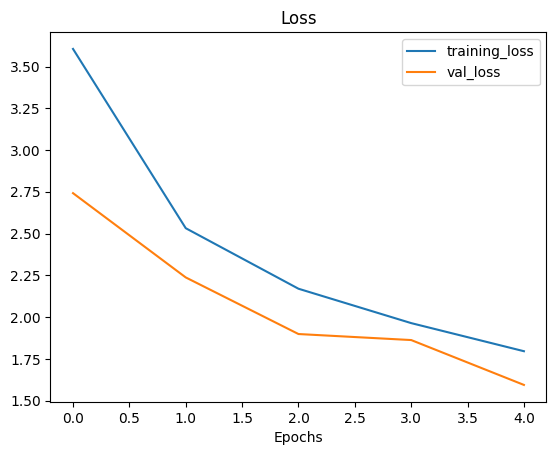

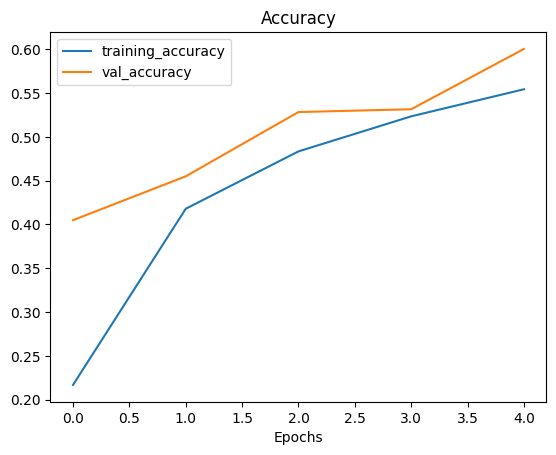

In [99]:
plot_loss_curves(history_all_classes_10_percent)

> 🤔 **Question:** What do these curves suggest? Hint: ideally, the two curves should be very similar to each other, if not, there may be some overfitting or underfitting.

### **Fine Tuning after the last Feature Extraction**

In [100]:
# unfreezing
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

After making changes to our model's layers, what do we need to do?

Recompile it.

Since we’re fine-tuning, we’ll lower the learning rate by 10x to prevent large updates to the pre-trained weights.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/06-lowering-the-learning-rate.png)
*When fine-tuning and unfreezing layers of a pre-trained model, it's common to lower the learning rate by 10x to ensure gradual adjustments to the weights.*


In [101]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=["accuracy"])


In [102]:
# what layers in model --> trainable
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [103]:
# check whick is traiable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer_5 False
1 rescaling_4 False
2 normalization_3 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [104]:
fine_tune_epochs = 10
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])


Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 980s 4s/step - accuracy: 0.5644 - loss: 1.7861 - val_accuracy: 0.4955 - val_loss: 1.9997
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 912s 4s/step - accuracy: 0.6177 - loss: 1.5682 - val_accuracy: 0.5360 - val_loss: 1.7690
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 878s 4s/step - accuracy: 0.6327 - loss: 1.4761 - val_accuracy: 0.6001 - val_loss: 1.5901
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 843s 3s/step - accuracy: 0.6450 - loss: 1.4377 - val_accuracy: 0.5712 - val_loss: 1.6477
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 888s 4s/step - accuracy: 0.6619 - loss: 1.3697 - val_accuracy: 0.6224 - val_loss: 1.4509
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 841s 4s/step - accuracy: 0.6845 - loss: 1.2906 - val_accuracy: 0.5900 - val_loss: 1.4849



Once again, during training we were only evaluating on a small portion of the test data, let's find out how our model went on all of the test data.

In [105]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 ━━━━━━━━━━━━━━━━━━━━ 1653s 2s/step - accuracy: 0.5515 - loss: 1.7168


[1.619576096534729, 0.5714455246925354]

Hmm... it seems like our model got a slight boost from fine-tuning.

We might get a better picture by using our `compare_historys()` function and seeing what the training curves say.

In [ ]:
compare_history(original_history=history_all_classes_10_percent,
                new_history=history_all_classes_10_percent_fine_tune,
                initial_epochs=5)


After fine-tuning, our model’s training metrics improved significantly, but validation performance didn’t improve as much. It seems the model is starting to overfit.

This is common. Fine-tuning often leads to overfitting, especially when the pre-trained model’s data is similar to your custom dataset.

In our case, the pre-trained `EfficientNetB0` model was trained on [ImageNet](http://www.image-net.org/index), which contains many real-life pictures of food, similar to our dataset.

If feature extraction works well, fine-tuning might not show large improvements, especially if the base model’s data is closely related to your own.


## **Evaluating the performance of the big dog model across all different classes**


In [107]:
loaded_loss, loaded_accuracy =results_all_classes_10_percent_fine_tune[0], results_all_classes_10_percent_fine_tune[1]

### Making predictions with our trained model

To evaluate the model, we need to make predictions and compare them to the test dataset.

Since the model has never seen the test data, this helps us gauge its performance on real-world data similar to what it has been trained on.

We use the `predict()` method, passing the test data. As the data is multi-class, the model will return a prediction tensor for each sample, showing how likely each image is to belong to each of the 101 classes.


In [ ]:
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take

608/790 ━━━━━━━━━━━━━━━━━━━━ 6:28 2s/step

In [ ]:
len(pred_probs)

And if each image could be one of 101 classes, how many predictions do you think we'll have for each image?

In [ ]:
pred_probs.shape

In [ ]:
pred_probs[:10]

In [ ]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

In [ ]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

We now have the predicted class index for each sample in our test dataset, which we can compare to the test dataset labels to further evaluate the model.

To access the test dataset labels, we can unravel our `test_data` object (a `tf.data.Dataset`) using the [`unbatch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#unbatch) method. This gives us the images and labels, and since the labels are one-hot encoded, we'll use the `argmax()` method to get the index of the label.

> 🔑 **Note:** We use `shuffle=False` when creating the test dataset to avoid shuffling the data, ensuring the predictions and labels are in the same order for comparison.


In [ ]:
y_labels=[]
for image, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10] # check that successive images at the same class "unshaffled"

In [ ]:
len(y_labels)

### Evaluating our models predictions

A very simple evaluation is to use Scikit-Learn's [`accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function which compares truth labels to predicted labels and returns an accuracy score.

If we've created our `y_labels` and `pred_classes` arrays correctly, this should return the same accuracy value (or at least very close) as the `evaluate()` method we used earlier.

In [ ]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

In [ ]:
import numpy as np
print(f"Close? {np.isclose(loaded_accuracy, sklearn_accuracy)} | Difference: {loaded_accuracy - sklearn_accuracy}")

Okay, it looks like our `pred_classes` array and `y_labels` arrays are in the right orders.

How about we get a little bit more visual with a confusion matrix?

To do so, we'll use our `make_confusion_matrix` function we created in a previous notebook.

In [ ]:
from helper_functions import make_confusion_matrix

In [ ]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusions_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10,10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  cm = confusions_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  n_classes = cm.shape[0]

  fig, ax= plt.subplots(figsize=figsize)
  cax = ax.matshow(cm , cmap=plt.cm.Blues)# colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  ax.set(title="Confusion Matric",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  # make x-axis labels appear on bottom
  ax.xaxis.set_position("bottom")
  ax.xaxis.tick_bottom()

  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # set threshold for differner colos
  threshold= (cm.max() + cm.min()) / 2.

  # plot text
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
class_names = test_data.class_names
class_names[:10]

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

Woah! That’s a big confusion matrix. While it might seem daunting, a closer look reveals useful insights into which classes our model is confusing.

The good news: most predictions fall along the top-left to bottom-right diagonal, meaning they're correct.

The model seems to struggle with visually similar classes, like predicting `filet_mignon` for `pork_chop` and `chocolate_cake` for `tiramisu`.

To further evaluate, we can use Scikit-Learn’s [`classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) function to gain detailed metrics on our model’s performance.


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

The `classification_report()` provides precision, recall, and F1-score for each class:

* **Precision**: Proportion of true positives out of total predicted positives. Higher precision means fewer false positives.
* **Recall**: Proportion of true positives out of total actual positives. Higher recall means fewer false negatives.
* **F1-score**: Harmonic mean of precision and recall, ranging from 0 (worst) to 1 (best).

While informative, the output can be overwhelming with many classes. To make it clearer, let's use a visualization.

First, we'll retrieve the `classification_report()` output as a dictionary by setting `output_dict=True`.


In [ ]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

Alright, there's still a fair few values here, how about we narrow down?

Since the f1-score combines precision and recall in one metric, let's focus on that.

To extract it, we'll create an empty dictionary called `class_f1_scores` and then loop through each item in `classification_report_dict`, appending the class name and f1-score as the key, value pairs in `class_f1_scores`.

In [ ]:
class_f1_scores = {}
for k,v in classification_report_dict.items():
  if k == "accuracy": # stop once get accuracy key
  break
    """
'100': {'precision': 0.5912162162162162,
  'recall': 0.7,
  'f1-score': 0.641025641025641,
  'support': 250},
 'accuracy': 0.6078019801980198,
   """
  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

Looking good!

It seems like our dictionary is ordered by the class names. However, I think if we're trying to visualize different scores, it might look nicer if they were in some kind of order.

How about we turn our `class_f1_scores` dictionary into a pandas DataFrame and sort it in ascending fashion?

In [ ]:
import pandas as pd

f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                         "f1-score": list(class_f1_scores.values())}).sort_values("f1-scores", ascending=False)
f1_scores.head()

Now we're talking! Let's finish it off with a nice horizontal bar chart.



In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,25))
# Creating a horizontal bar chart with F1 scores for each class
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-scores"].values)
# Setting the y-axis ticks and labels to match the class names
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))

ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 101 Different Classes")
ax.invert_yaxis(); # reverse oreder

# Define a function to label each bar with its F1 score
def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width: 0.2f}",
            ha='center', va='bottom')
autolabel(scores)


Auto-Label Function: autolabel adds text labels to the bars, positioning them slightly to the right of each bar and displaying each score to two decimal places for readability.

Nice graph! The text positioning could use a tweak, but it’s good for now.

See how visualizing predictions reveals more about our model’s performance? Previously, we just had an accuracy score, but now we see performance across each class.

Our model struggles with classes like `apple_pie` and `ravioli` but shines with `edamame` and `pho`. These insights suggest next steps: gathering more data for tough classes or considering if they’re simply harder to classify.

> 🛠 **Exercise:** Try visualizing the lowest-performing classes. Do you notice any patterns?


### Visualizing Predictions on Test Images

Now, let's put our model to the real test: visualizing predictions on actual images. Metrics are useful, but seeing predictions on images offers a clearer picture of model performance.

Currently, our model requires an image loaded as a tensor for predictions. So, we'll create a function to load any image into a tensor format.

The function will:
* Use [`tf.io.read_file()`](https://www.tensorflow.org/api_docs/python/tf/io/read_file) to read in an image file path.
* Convert the image into a `Tensor` using [`tf.io.decode_image()`](https://www.tensorflow.org/api_docs/python/tf/io/decode_image).
* Resize the image to match the model's training size (224 x 224) with [`tf.image.resize()`](https://www.tensorflow.org/api_docs/python/tf/image/resize).
* Scale pixel values between 0 and 1, if needed.


In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # read image
  img = tf.io.read_file(filename)
  # conversion
  img = tf.io.decode_image(img)
  # resize
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    return img/255.
  else:
    return img

### Loading and Predicting on Test Images

With our image loading and preprocessing function ready, let's move on to visualizing the model's predictions. The following steps will help us see how the model performs on real test images:

1. **Load** a few random images from the test dataset.
2. **Make Predictions** on these images using our trained model.
3. **Plot the Results** showing the original image alongside:
   - The **predicted label**
   - The **prediction probability**
   - The **ground truth label**

Let's dive into the code!


In [ ]:
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir+"/"+class_name))
  filepath = test_dir + class_name + "/" + filename

  img = load_and_prep_image(filepath, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():0.2f}", c=title_color)
  plt.axis(False)

### Finding the Most Wrong Predictions

To gain deeper insights into our model's performance, we can analyze the instances where the model is highly confident but still makes wrong predictions. Here's how we can do this:

1. **Get image file paths**: Use the `list_files()` method to gather all file paths in the test dataset.
2. **Create a DataFrame**: We will create a pandas DataFrame containing the image paths, true labels, predicted labels, and prediction probabilities.
3. **Identify wrong predictions**: Find all instances where the predicted label does not match the true label.
4. **Sort by probability**: Sort the DataFrame by the highest prediction probabilities for wrong predictions.
5. **Visualize wrong predictions**: Display images where the model was most confident but incorrect.

This will help pinpoint areas where the model may need more data or improvements.


In [ ]:
filepaths=[]
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

Now we've got all of the test image filepaths, let's combine them into a DataFrame along with:
* Their ground truth labels (`y_labels`).
* The class the model predicted (`pred_classes`).
* The maximum prediction probabilitity value (`pred_probs.max(axis=1)`).
* The ground truth class names.
* The predicted class names.

In [ ]:
# Create a dataframe out of current prediction data for analysis
import pandas as pd

pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1),   # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df.head()

In [ ]:
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

And now since we know which predictions were right or wrong and along with their prediction probabilities, how about we get the 100 "most wrong" predictions by sorting for wrong predictions and descending prediction probabilties?

In [ ]:
# get top 100 wrong ex

top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(10)

Very interesting... just by comparing the ground truth classname (`y_true_classname`) and the prediction classname column (`y_pred_classname`), do you notice any trends?

It might be easier if we visualize them.

In [ ]:
images_to_view = 9
start_index = 10
plt.figure(figsize=(15,10))
for i, row in enumerate(top_100_wrong[start_index:start_index+image_to_view].itertuples()):
  plt.subplot(3,3,i+1)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_true} \nprob: {pred_prob:.2f}")
  plt.axis(False)

### Insights from the Model's Most Wrong Predictions

Going through the model's most wrong predictions can reveal a few things:

* **Incorrect Labels**: If the model predicts correctly but the ground truth is wrong, we can use the model to improve our dataset labels. This process is called [**active learning**](https://blog.scaleway.com/active-learning-some-datapoints-are-more-equal-than-others/), where the model helps identify mislabeled data.
* **Need for More Samples**: If certain classes are consistently misclassified, collecting more diverse samples for those classes can help improve future models.


## Test the model on custom food images

We've visualized predictions from the test dataset, but now let's test our model on custom food images. You can upload your own images to Google Colab or place them in a folder to load into the notebook. I've prepared a small dataset of six food images. Let's download and unzip them.


In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

In [ ]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

In [ ]:
# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

Two thumbs up! How cool is that?! Our Food Vision model has come to life!

Seeing a machine learning model work on a premade test dataset is cool but seeing it work on your own data is mind blowing.

And guess what... our model got these incredible results (10%+ better than the baseline) with only 10% of the training images.

I wonder what would happen if we trained a model with all of the data (100% of the training data from Food101 instead of 10%)? Hint: that's your task in the next notebook.

## 🛠 Exercises

1. Take 3 of your own photos of food and use the trained model to make predictions on them, share your predictions with the other students in Discord and show off your Food Vision model 🍔👁.
2. Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook). Which method is better?
3. Recreate our first model (the feature extraction model) with [`mixed_precision`](https://www.tensorflow.org/guide/mixed_precision) turned on.
  * Does it make the model train faster?
  * Does it effect the accuracy or performance of our model?
  * What's the advatanges of using `mixed_precision` training?

## 📖 Extra-curriculum

* Spend 15-minutes reading up on the [EarlyStopping callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping). What does it do? How could we use it in our model training?
* Spend an hour reading about [Streamlit](https://www.streamlit.io/). What does it do? How might you integrate some of the things we've done in this notebook in a Streamlit app?